In [1]:


def wilson_amplitude(signal, th):
    #th=0
    x = abs(np.diff(signal.transpose()))
    #print(signal)
       
    umbral = x >= th
    #print('umbral x', x)
    return np.sum(umbral)


def myopulse(signal, th):
    
    umbral = signal >= th
    return np.sum(umbral) / len(signal)

def zcruce(X, th):
    X=X.transpose()
    #th = 0
    cruce = 0
    #print('X IN ZCRUCE', len(X))
    for cont in range(len(X) - 1-1):
        #print('CONT', cont)
        #print ('cont 0 is ' , X[cont])
        #print ('cont 1 is' , X[cont+1])
        can = X[cont] * X[cont + 1]
        can2 = abs(X[cont] - X[cont + 1])
        if can < 0 and can2 > th:
            cruce = cruce + 1
    return cruce

In [2]:
def time_features_estimation(signal):#, frame, step):
    #print(signal)

    variance = []
    rms = []
    iemg = []
    mav = []
    log_detector = []
    wl = []
    aac = []
    dasdv = []
    zc = []
    wamp = []
    myop = []

    th = np.mean(signal) + .3 * np.std(signal)
    #print('TH', th)

    #for i in range(frame, signal.size, step):
    x = signal#[i - frame:i]
    #print ('length of x', len(x))
    variance.append(np.var(x))
    rms.append(np.sqrt(np.mean(x ** 2)))
    iemg.append(np.sum(abs(x)))  # Integral
    mav.append(np.sum(np.absolute(x)) / len(x))  # Mean Absolute Value
    #log_detector.append(np.exp(np.sum(np.log10(np.absolute(x))) / len(x)))
    wl.append(np.sum(abs(np.diff(x.transpose()))))  # Wavelength
    aac.append(np.sum(abs(np.diff(x.transpose()))) / len(x))  # Average Amplitude Change
    dasdv.append(math.sqrt((1 / (len(x) - 1)) * np.sum((np.diff(x)) ** 2)))  # Difference absolute standard deviation value
    zc.append(zcruce(x.transpose(), th))  # Zero-Crossing
    wamp.append(wilson_amplitude(x, th))  # Willison amplitude
    myop.append(myopulse(x, th))  # Myopulse percentage rate
    #print('zc', zc)
    #print('wilson_amplitude', wl)
    #print('MYOP', myop)
    #time_features_matrix = np.column_stack((variance, rms, iemg, mav, log_detector, wl, aac, dasdv, zc, wamp, myop))
    time_features_matrix = np.column_stack((variance, rms, iemg, mav, wl, aac, dasdv, zc, wamp, myop))
    time_headers  = ('variance', 'rms', 'iemg', 'mav', 'wl', 'aac', 'dasdv', 'zc', 'wamp', 'myop')
    #print(time_features_matrix)                                                  
    return time_features_matrix,  time_headers


In [3]:

def time_fea(data_in):
    #print (data_in.shape)
    data = pd.DataFrame(data_in)
    time_matrix=[]
    time_matrix_df = []
    var_val = []
    HEA1=[]
    TFE1=[]
    #TFE3=[]
    no_of_ch = data.shape[1]#-1
    #print ('no_of_ch ',no_of_ch)
    for col in range(0,no_of_ch , 1):
        #print('COL NO = ', col)
        #print(data)
        data_in = data.iloc[:,col]
        #print('DATAIN ' , data_in)
        
        signal= pd.DataFrame(data_in.values)
        
        signal = signal.to_numpy()
        #print ('SIGNAL', signal)
        S,H = time_features_estimation(signal)
        #time_matrix.append(time_features_estimation(signal))
        #TFE = np.array(time_features_estimation(signal))
        TFE = np.array(S)
        HEA = np.array(H)
        if col == 0 :
            TFE1 = TFE
            HEA1 = HEA
            #print('First channel inner loop')
        else :
            TFE1 = np.hstack([TFE1,TFE])
            HEA1 =np.hstack([HEA1,HEA])
        #print('TFE1', TFE1)    
        #print(HEA1)
 
    return   TFE1,HEA1
    

In [4]:
def spectrum(signal, fs):
    m = len(signal)
    n = next_power_of_2(m)
    y = np.fft.fft(signal, n)
    yh = y[0:int(n / 2 - 1)]
    fh = (fs / n) * np.arange(0, n / 2 - 1, 1)
    power = np.real(yh * np.conj(yh) / n)
    #print('POWER', power.shape)
    return fh, power

def next_power_of_2(x):
    return 1 if x == 0 else 2 ** (x - 1).bit_length()


def frequency_ratio(frequency, power):
    #power_low = power[(frequency >= 30) & (frequency <= 250)]
    #power_high = power[(frequency > 250) & (frequency <= 500)]
    
    power_low = power[(frequency >= 10) & (frequency <= 250)]
    power_high = power[(frequency > 250) & (frequency <= 500)]
    ULC = np.sum(power_low)
    UHC = np.sum(power_high)

    return ULC / UHC

def mean_freq(frequency, power):
    num = 0
    den = 0
    for i in range(int(len(power) / 2)):
        num += frequency[i] * power[i]
        den += power[i]

    return num / den


def median_freq(frequency, power):
    power_total = np.sum(power) / 2
    temp = 0
    tol = 0.01
    errel = 1
    i = 0

    while abs(errel) > tol:
        temp += power[i]
        errel = (power_total - temp) / power_total
        i += 1
        #print('ERREL',errel )
        if errel < 0:
            errel = 0
            i -= 1

    return frequency[i]


In [5]:
def frequency_features_estimation(matrix, fs):
    

    fr = []
    mnp = []
    tot = []
    mnf = []
    mdf = []
    pkf = []

    for i in range(matrix.shape[1]):
        x = matrix[:,i]
        frequency, power = spectrum(x, fs)

        fr.append(frequency_ratio(frequency, power))  # Frequency ratio
        mnp.append(np.sum(power) / len(power))  # Mean power
        tot.append(np.sum(power))  # Total power
        mnf.append(mean_freq(frequency, power))  # Mean frequency
        #mdf.append(median_freq(frequency, power))  # Median frequency
        #pkf.append(frequency[power.argmax()])  # Peak frequency

        frequency_features_matrix = np.row_stack((fr, mnp, tot, mnf))#, mdf, pkf))
        #frequency_features_matrix = frequency_features_matrix.transpose()
        names = ['FR_' + str(i) for i in range(matrix.shape[1])]
        names.extend(['MNP_' + str(i) for i in range(matrix.shape[1])])
        names.extend(['TOT_' + str(i) for i in range(matrix.shape[1])])
        names.extend(['MNF_' + str(i) for i in range(matrix.shape[1])])
        #names.extend(['MDF_' + str(i) for i in range(matrix.shape[1])])
        #names.extend(['PKF_' + str(i) for i in range(matrix.shape[1])])
        #print ('FREQ FEA', frequency_features_matrix.shape, frequency_features_matrix)
        #print(names)
    freq_fea=np.array(frequency_features_matrix)
    freq_fea = freq_fea.reshape(-1)
    #print (freq_fea)
    #frequency_features_matrix = sum(frequency_features_matrix, [])# Converitn to one row
    return freq_fea, names

In [6]:
def wavelet_features(data):
    
    # Approximate and detailed coefficients
    A3_values = []
    D3_values = []
    D2_values = []
    D1_values = []
    
    # Mean, Standard Deviation, Energy and Entropy of the coefficients
    A3_mean = []
    A3_std = []
    A3_energy =[]
    A3_entropy = []
    
    D3_mean = []
    D3_std = []
    D3_energy = []
    D3_entropy = []
    
    D2_mean = []
    D2_std = []
    D2_energy = []
    D2_entropy = []
    
    D1_mean = []
    D1_std = []
    D1_energy = []
    D1_entropy = []
    
    #print('IP MAT LENGTH TO WT', len(data))
    # Discrete Wavelet Transform
    #for i in range(len(data)):
    A3, D3, D2, D1 = pywt.wavedec(data, 'db4', level=3)
    A3_values.append(A3)
    D3_values.append(D3)
    D2_values.append(D2)
    D1_values.append(D1)
    #print ('WAVELET', A3, D3, D2, D1)   
    A3_mean = np.mean(A3)
    #print('A3 MEAN', A3_mean)
    A3_std = np.std(A3)
    #print('A3 STD', A3_std)
    A3_energy = np.sum(np.square(A3))
    #print('A3 ENERGY', A3_energy)
    A3_entropy = np.sum(np.square(A3) * np.log(np.square(A3)))
    #print('A3 ENTROPY', A3_entropy)
    
    D3_mean = np.mean(D3)
    #print('D3 MEAN', D3_mean)
    D3_std = np.std(D3)
    #print('D3 STD', D3_std)
    D3_energy = np.sum(np.square(D3))
    #print('D3 ENERGY', D3_energy)
    D3_entropy = np.sum(np.square(D3) * np.log(np.square(D3)))
    #print('D3 ENTROPY', D3_entropy)
    
    D2_mean = np.mean(D2)
    #print('D2 MEAN', D2_mean)
    D2_std = np.std(D2)
    #print('D2 STD', D2_std)
    D2_energy = np.sum(np.square(D2))
    #print('D2 ENERGY', D2_energy)
    D2_entropy = np.sum(np.square(D2) * np.log(np.square(D2)))
    #print('D2 ENTROPY', D2_entropy)
    
    D1_mean = np.mean(D1)
    #print('D1 MEAN', D1_mean)
    D1_std = np.std(D1)
    #print('D1 STD', D1_std)
    D1_energy = np.sum(np.square(D1))
    #print('D1 ENERGY', D1_energy)
    D1_entropy = np.sum(np.square(D1) * np.log(np.square(D1)))
    #print('D1 ENTROPY', D1_entropy)
    ret = np.column_stack((A3_mean, A3_std, A3_energy, A3_entropy, D3_mean, D3_std, D3_energy, D3_entropy,  
                     D2_mean, D2_std, D2_energy, D2_entropy,  D1_mean, D1_std, D1_energy, D1_entropy))
    #ret = np.hstack([A3_mean, A3_std, A3_energy, A3_entropy, D3_mean, D3_std, D3_energy, D3_entropy,  
    #                 D2_mean, D2_std, D2_energy, D2_entropy,  D1_mean, D1_std, D1_energy, D1_entropy])
    header = ('A3_mean', 'A3_std', 'A3_energy', 'A3_entropy', 'D3_mean', 'D3_std', 'D3_energy', 'D3_entropy', 
            'D2_mean', 'D2_std', 'D2_energy', 'D2_entropy', 'D1_mean', 'D1_std', 'D1_energy', 'D1_entropy')
    
    
    return ret, header

In [7]:
def flatten(A):
    rt = []
    for i in A:
        if isinstance(i,list): rt.extend(flatten(i))
        else: rt.append(i)
    return rt

In [8]:
import pywt


def wavelet_energy(x, mother, nivel):
    coeffs = pywt.wavedecn(x, wavelet=mother, level=nivel)
    #coeffs = pywt.wavedec([1,2,3,4,5,6,7,8], 'db1', level=2)
    arr, _ = pywt.coeffs_to_array(coeffs)
    et = np.sum(arr ** 2)
    #print('et is', et)
    ca = coeffs[0]
    ea = 100 * np.sum(ca ** 2) / et
    ed = []
    #print(coeffs)

    for k in range(1, len(coeffs)):
        cd = list(coeffs[k].values())
        #cd = coeffs[k].values()
        cd = np.array(cd)
        # print('cd array is',cd)
        # tcd = np.arange(len(cd))
        #plt.plot(tcd, cd)
        #print(f'cd  is {cd}.')
        #print(cd.size)
        power = (np.abs(cd)) ** 2
        #print (cd**2)
        
        ed.append(100 * np.sum(cd ** 2) / et)
        #ed.append(100 * np.sum(cd * cd) / et)

    return ea, ed

def time_frequency_features_estimation(matrix):
 
    h_wavelet = []
    all_wav_df =[]
    all_header_wav = []
    all_header_wav1 = []
    all_wav_df1 =[]
    all_wav_df1 = np.array(all_wav_df1)
    all_header_wav1 = np.array(all_header_wav1)
    
    #print('size of signal',matrix.shape)

    for i in range(matrix.shape[1]):
        x = matrix[:,i]
        #print('THIS IS THE CHANNEL INDEX', i)
        #print('FIRsT CH SIZE', x.shape)
        E_a, E = wavelet_energy(x, 'db2', 4)
        wav_df, header_wav = wavelet_features(x) # mean std energy entropy
        wav_df_1 = np.array(wav_df)
        header_wav_1 = np.array(header_wav)
        #print('wav_df', wav_df)
        #print('header_wav', header_wav)
        #print ('ea e', E_a, E )
        #E_a, E = wavelet_energy(x, 'haar', 5)
        E.insert(0, E_a)
        E = np.asarray(E) / 100
        #print('E', E)
        #print('sum(E * np.log2(E))', sum(E * np.log2(E)))
        h_wavelet.append(-np.sum(E * np.log2(E)))
        all_wav_df.append(wav_df)
        all_header_wav.append(header_wav)
        
        #wav_df = wav_df.reshape(16)
        #header_wav =  header_wav.reshape(16)
        if i== 0: #all_wav_df1 is None:
            all_wav_df1 =  wav_df_1
            all_header_wav1 =  header_wav_1
        else:
            all_wav_df1 = np.hstack([all_wav_df1,wav_df]) 
            all_header_wav1 =  np.hstack([all_header_wav1,header_wav_1])  
        
        l = all_wav_df1
        flatten_list = []
        for subl in l:
            for item in subl:
                flatten_list.append(item)
        #print('flatten_list',flatten_list)
        '''
        l_h = all_header_wav1
        flatten_list_h = []
        for subl_h in l_h:
            for item in subl_h:
                flatten_list_h.append(item)
        #print('flatten_list H',flatten_list_h)
        '''
        rt = flatten(all_header_wav1)
        #print('RT',rt)
        
        #print('all_wav_df1', all_wav_df1)
        #print('all_header_wav1',all_header_wav1)
    #print('WAVELET H',h_wavelet )
    names = ['WAV_' + str(i) for i in range(matrix.shape[1])]
    
    #print(names)
    #print(h_wavelet)
    return h_wavelet, names, flatten_list,rt #.astype(str) 

In [12]:



import scipy
import scipy.signal
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np

import xlrd



def matrix_from_csv_file(file_path):
    
    csv_data = np.genfromtxt(file_path, delimiter = ',')
    #df = pd.read_csv(file_path,  sep=',')#, encoding='gbk')
    full_matrix = csv_data[2:] #csv_data.iloc [2:] #
    #print ('FULL MATRIX SHAPE', full_matrix.shape)
    return full_matrix

def get_slice (full_matrix,  t, frame):
    #tot_len = full_matrix[:,0].size
    #tot_len = len(full_matrix[:,0])#.size
    
    restart = full_matrix[0, 0] + t
    index_0 = int(restart)
    index_1 = int(restart + frame)
    #print('index_0', index_0)
    #print('index_1', index_1)
    duration = frame#full_matrix[index_1, 0] - full_matrix[index_0, 0]
    #print('Duration is', duration )
    #print('FULL MATRIX ', full_matrix[index_0:index_1, :])
    return full_matrix [index_0:index_1, :], duration




def notch_filter(x, samplerate, plot=False):
    x = x - np.mean(x)

    high_cutoff_notch = 49 / (samplerate / 2)
    low_cutoff_notch = 51 / (samplerate / 2)

    # Band Stop Filter (BSF) or Band Reject Filter
    [b, a] = signal.butter(4, [high_cutoff_notch, low_cutoff_notch], btype='stop')

    x_filt = signal.filtfilt(b, a, x.T)

    if plot:
        t = np.arange(0, len(x) / samplerate, 1 / samplerate)
        plt.plot(t, x)
        plt.plot(t, x_filt.T, 'k')
        plt.autoscale(tight=True)
        plt.xlabel('Time')
        plt.ylabel('Amplitude (mV)')
        plt.show()

    return x_filt


def bp_filter(x, low_f, high_f, samplerate, plot=False):
    # x = x - np.mean(x)

    low_cutoff_bp = low_f / (samplerate / 2)
    high_cutoff_bp = high_f / (samplerate / 2)

    [b, a] = signal.butter(5, [low_cutoff_bp, high_cutoff_bp], btype='bandpass')

    x_filt = signal.filtfilt(b, a, x)
    #print(len(x))

    if plot:
        t = np.arange(0, len(x.transpose()) / samplerate, 1 / samplerate)
        plt.plot(t, x.transpose())
        plt.plot(t, x_filt.transpose(), 'k')
        plt.autoscale(tight=True)
        plt.xlabel('Time')
        plt.ylabel('Amplitude (mV)')
        plt.show()

    return x_filt



def feature_mean(matrix):
  
    ret = np.mean(matrix, axis = 0).flatten()
    #print('MEAN RET VALUE',ret )
    names = ['mean_' + str(i) for i in range(matrix.shape[1])]
    return ret, names



def feature_mean_d(h1, h2):

    ret = (feature_mean(h2)[0] - feature_mean(h1)[0]).flatten()


    # Fixed naming [fcampelo]
    names = ['mean_d_h2h1_' + str(i) for i in range(h1.shape[1])]
    return ret, names



def feature_mean_q(q1, q2, q3, q4):

    v1 = feature_mean(q1)[0]
    v2 = feature_mean(q2)[0]
    v3 = feature_mean(q3)[0]
    v4 = feature_mean(q4)[0]
    ret = np.hstack([v1, v2, v3, v4, 
                     v1 - v2, v1 - v3, v1 - v4, 
                     v2 - v3, v2 - v4, v3 - v4]).flatten()


    # Fixed naming [fcampelo]
    names = []
    for i in range(4): # for all quarter-windows
        names.extend(['mean_q' + str(i + 1) + "_" + str(j) for j in range(len(v1))])

    for i in range(3): # for quarter-windows 1-3
        for j in range((i + 1), 4): # and quarter-windows (i+1)-4
            names.extend(['mean_d_q' + str(i + 1) + 'q' + str(j + 1) + "_" + str(k) for k in range(len(v1))])

    return ret, names




def feature_stddev(matrix):
 


    # fix ddof for finite sampling correction (N-1 instead of N in denominator)
    ret = np.std(matrix, axis = 0, ddof = 1).flatten()
    names = ['std_' + str(i) for i in range(matrix.shape[1])]

    return ret, names



def feature_stddev_d(h1, h2):
 

    ret = (feature_stddev(h2)[0] - feature_stddev(h1)[0]).flatten()

    # Fixed naming [fcampelo]
    names = ['std_d_h2h1_' + str(i) for i in range(h1.shape[1])]

    return ret, names




def feature_moments(matrix):
 

    skw = scipy.stats.skew(matrix, axis = 0, bias = False)
    krt = scipy.stats.kurtosis(matrix, axis = 0, bias = False)
    ret  = np.append(skw, krt)
    #print('MOMENTS SHAPE' , ret.shape)
    names = ['skew_' + str(i) for i in range(matrix.shape[1])]
    names.extend(['kurt_' + str(i) for i in range(matrix.shape[1])])
    return ret, names




def feature_max(matrix):
  

    ret = np.max(matrix, axis = 0).flatten()
    names = ['max_' + str(i) for i in range(matrix.shape[1])]
    return ret, names



def feature_max_d(h1, h2):
   

    ret = (feature_max(h2)[0] - feature_max(h1)[0]).flatten()

    # Fixed naming [fcampelo]
    names = ['max_d_h2h1_' + str(i) for i in range(h1.shape[1])]
    return ret, names


def feature_max_q(q1, q2, q3, q4):
 
    v1 = feature_max(q1)[0]
    v2 = feature_max(q2)[0]
    v3 = feature_max(q3)[0]
    v4 = feature_max(q4)[0]
    ret = np.hstack([v1, v2, v3, v4, 
                     v1 - v2, v1 - v3, v1 - v4, 
                     v2 - v3, v2 - v4, v3 - v4]).flatten()


    # Fixed naming [fcampelo]
    names = []
    for i in range(4): # for all quarter-windows
        names.extend(['max_q' + str(i + 1) + "_" + str(j) for j in range(len(v1))])

    for i in range(3): # for quarter-windows 1-3
        for j in range((i + 1), 4): # and quarter-windows (i+1)-4
            names.extend(['max_d_q' + str(i + 1) + 'q' + str(j + 1) + "_" + str(k) for k in range(len(v1))])

    return ret, names


def feature_min(matrix):
  
    ret = np.min(matrix, axis = 0).flatten()
    names = ['min_' + str(i) for i in range(matrix.shape[1])]
    return ret, names



def feature_min_d(h1, h2):
    """
    Computes the change in min values (backward difference) of all signals 
    between the first and second half-windows, min(h2) - min(h1)

   
    """

    ret = (feature_min(h2)[0] - feature_min(h1)[0]).flatten()

    # Fixed naming [fcampelo]
    names = ['min_d_h2h1_' + str(i) for i in range(h1.shape[1])]
    return ret, names


def feature_min_q(q1, q2, q3, q4):
    """
    Computes the min values of each signal for each quarter-window, plus the 
    paired differences of min values of each signal for the quarter-windows, 
    i.e., feature_min(q1), feature_min(q2), feature_min(q3), feature_min(q4),
    (feature_min(q1) - feature_min(q2)), (feature_min(q1) - feature_min(q3)),
    ...

    """
    v1 = feature_min(q1)[0]
    v2 = feature_min(q2)[0]
    v3 = feature_min(q3)[0]
    v4 = feature_min(q4)[0]
    ret = np.hstack([v1, v2, v3, v4, 
                     v1 - v2, v1 - v3, v1 - v4, 
                     v2 - v3, v2 - v4, v3 - v4]).flatten()


    # Fixed naming [fcampelo]
    names = []
    for i in range(4): # for all quarter-windows
        names.extend(['min_q' + str(i + 1) + "_" + str(j) for j in range(len(v1))])

    for i in range(3): # for quarter-windows 1-3
        for j in range((i + 1), 4): # and quarter-windows (i+1)-4
            names.extend(['min_d_q' + str(i + 1) + 'q' + str(j + 1) + "_" + str(k) for k in range(len(v1))])

    return ret, names


def feature_covariance_matrix(matrix):
    """
    Computes the elements of the covariance matrix of the signals. Since the 
    covariance matrix is symmetric, only the lower triangular elements 
    (including the main diagonal elements, i.e., the variances of eash signal) 
    are returned. 

 
    """

    covM = np.cov(matrix.T)
    indx = np.triu_indices(covM.shape[0])
    ret  = covM[indx]

    names = []
    for i in np.arange(0, covM.shape[1]):
        for j in np.arange(i, covM.shape[1]):
            names.extend(['covM_' + str(i) + '_' + str(j)])
    #print('COVM VALUE ',ret )
    return ret, names, covM


def feature_eigenvalues(covM):
    """
    Computes the eigenvalues of the covariance matrix passed as the function 
    argument.

    Parameters:
        covM (numpy.ndarray): 2D [nsignals x nsignals] covariance matrix of the 
        signals in a time window

  
    """

    ret   = np.linalg.eigvals(covM).flatten()
    names = ['eigenval_' + str(i) for i in range(covM.shape[0])]
    #print('EIGRN VALUE',ret )
    return ret, names


def feature_logcov(covM):
    """
    Computes the matrix logarithm of the covariance matrix of the signals. 
      
    """
    log_cov = scipy.linalg.logm(covM)
    indx = np.triu_indices(log_cov.shape[0])
    ret  = np.abs(log_cov[indx])

    names = []
    for i in np.arange(0, log_cov.shape[1]):
        for j in np.arange(i, log_cov.shape[1]):
            names.extend(['logcovM_' + str(i) + '_' + str(j)])

    return ret, names, log_cov



def feature_fft(matrix, period = 1., mains_f = 50., 
                filter_mains = True, filter_DC = True,
                normalise_signals = True,
                ntop = 10, get_power_spectrum = True):
   
    # Signal properties
    N   = matrix.shape[0] # number of samples
    T = period / N        # Sampling period

    # Scale all signals to interval [-1, 1] (if requested)
    if normalise_signals:
        matrix = -1 + 2 * (matrix - np.min(matrix)) / (np.max(matrix) - np.min(matrix))

    # Compute the (absolute values of the) FFT
    # Extract only the first half of each FFT vector, since all the information
    # is contained there (by construction the FFT returns a symmetric vector).
    fft_values = np.abs(scipy.fft.fft(matrix, axis = 0))[0:N//2] * 2 / N

    # Compute the corresponding frequencies of the FFT components
    freqs = np.linspace(0.0, 1.0 / (2.0 * T), N//2)

    # Remove DC component (if requested)
    if filter_DC:
        fft_values = fft_values[1:]
        freqs = freqs[1:]

    # Remove mains frequency component(s) (if requested)
    if filter_mains:
        indx = np.where(np.abs(freqs - mains_f) <= 1)
        fft_values = np.delete(fft_values, indx, axis = 0)
        freqs = np.delete(freqs, indx)

    # Extract top N frequencies for each signal
    indx = np.argsort(fft_values, axis = 0)[::-1]
    indx = indx[:ntop]

    ret = freqs[indx].flatten(order = 'F')

    # Make feature names
    names = []
    for i in np.arange(fft_values.shape[1]):
        names.extend(['topFreq_' + str(j) + "_" + str(i) for j in np.arange(1,11)])

    if (get_power_spectrum):
        ret = np.hstack([ret, fft_values.flatten(order = 'F')])

        for i in np.arange(fft_values.shape[1]):
            names.extend(['freq_' + "{:03d}".format(int(j)) + "_" + str(i) for j in 10 * np.round(freqs, 1)])
            #print ('Names', names)
    return ret, names


def calc_feature_vector(matrix, state, fs):
    """
    Calculates all previously defined features and concatenates everything into 
    a single feature vector.


    """

    # Extract the half- and quarter-windows
    h1, h2 = np.split(matrix, [ int(matrix.shape[0] / 2) ])
    q1, q2, q3, q4 = np.split(matrix, 
                              [int(0.25 * matrix.shape[0]), 
                               int(0.50 * matrix.shape[0]), 
                               int(0.75 * matrix.shape[0])])

    var_names = []	
    
    x, v = feature_mean(matrix) #1
    var_names += v
    var_values = x
    
    '''
    x, v = feature_mean_d(h1, h2) #2
    var_names += v
    var_values = np.hstack([var_values, x])
    '''
    '''
    x, v = feature_mean_q(q1, q2, q3, q4) # per channel 10 features
    var_names += v
    #print('this Feature shape', var_values.shape)
    var_values = np.hstack([var_values, x])
    '''
    '''
    x, v = feature_stddev(matrix)#3
    var_names += v
    var_values = np.hstack([var_values, x])
    
    
    x, v = feature_stddev_d(h1, h2) #4
    var_names += v
    var_values = np.hstack([var_values, x])
    '''
    x, v = feature_moments(matrix)  # per channel 2 features # 5 6 
    var_names += v
    var_values = np.hstack([var_values, x])
     
    x, v = feature_max(matrix)
    var_names += v
    var_values = np.hstack([var_values, x]) # 7
    
    x, v = feature_max_d(h1, h2)
    var_names += v
    var_values = np.hstack([var_values, x]) # 8
    
    
    '''
    x, v = feature_max_q(q1, q2, q3, q4) # per channel 10 features
    var_names += v
    var_values = np.hstack([var_values, x])
    

    x, v = feature_min(matrix)
    var_names += v
    var_values = np.hstack([var_values, x])

    x, v = feature_min_d(h1, h2)
    var_names += v
    var_values = np.hstack([var_values, x])
    
    x, v = feature_min_q(q1, q2, q3, q4) 
    var_names += v
    var_values = np.hstack([var_values, x])
    
    x, v, covM = feature_covariance_matrix(matrix) # 10 Fea per channel
    var_names += v
    var_values = np.hstack([var_values, x])

    x, v = feature_eigenvalues(covM) # 4 fea per channel
    var_names += v
    var_values = np.hstack([var_values, x])
    
   
    x, v, log_cov = feature_logcov(covM) # DO NOT USE
    var_names += v
    var_values = np.hstack([var_values, x])
    '''
    '''
    x, v = feature_fft(matrix)
    var_names += v
    var_values = np.hstack([var_values, x]) 
    #print('Feature  shape', var_values.shape)
    '''
    
    x1,v1, x,v = time_frequency_features_estimation(matrix) #Wavelet Domain  
    #h_wavelet, names, wav_df,header_wav
    #print('TIME FREQ ESTIMATION val ', x)
    #print('TIME FREQ ESTIMATION hea ', v)
    #print('var_names', var_names)
    #xs = np.transpose(x)
    #stacked_val = np.hstack ([var_values, xs])
    #stacked_names = np.hstack ([stacked_names, v])
        
    var_names += v
    var_values = np.hstack([var_values, x]) 
    
    x,v = frequency_features_estimation(matrix, fs) # Freq Domain (4fea) 16
    var_names += v
    var_values = np.hstack([var_values, x]) 
    
    if state != None:
        var_values = np.hstack([var_values, np.array([state])])
        var_names += ['Label']
    #print('var_values', var_values)
    #print('var_names', var_names)
    #print('all val values shape', var_values.shape)
    return var_values, var_names
    
    
    
    #time_frequency_matrix = time_frequency_features_estimation(signal, frame, step)
    #total_feature_matrix = pd.DataFrame(np.column_stack((time_matrix, frequency_matrix, time_frequency_matrix)).T, index=features_names)


"""
Returns a number of feature vectors from a labeled CSV file, and a CSV header 

"""
def generate_feature_vectors_from_samples(file_path, nsamples, period, 
                                          state = None, 
                                          remove_redundant = True,
                                          cols_to_ignore = None):
    """
    Reads data from CSV file in "file_path" and extracts statistical features 
    for each time window of width "period". 
  
    """	
    # Read the matrix from file
    matrix = matrix_from_csv_file(file_path)
    samplerate = 512
    low_f = 10
    high_f = 200
    
    t = 0.

    # No previous vector is available at the start
    previous_vector = None
    r_all  = None
    #print('previous_vector first posn', previous_vector)
    # Initialise empty return object
    ret = None
    
    s,dur = get_slice (matrix,  t, nsamples)
    #print('s  slice SHAPE first ', s.shape)
    # Until an exception is raised or a stop condition is met
    while True:
        # Get the next slice from the file (starting at time 't', with a 
        # duration of 'period'
        # If an exception is raised or the slice is not as long as we expected, 
        # return the current data available
        try:
            
            t=t+(nsamples/2)
            s,dur = get_slice (matrix, t,nsamples)
            
            #print('s slice shape in try ', s.shape)
            if cols_to_ignore is not None:
                s = np.delete(s, cols_to_ignore, axis = 1)
        except IndexError:
            break
        if len(s) == 0:
            #print('Length is zero')
            break
        if dur < 0.9 * period:
            #print(' Duration is less')
            break

        # Perform the resampling of the vector
                
        #sig = (s[:, 1:])
        # Perform the resampling of the vector

        sig1, rx = scipy.signal.resample(s[:, 1:], num = nsamples,  t = s[:, 0], axis =0)
        
        #print(' sig1 notch ip shape is', sig1.shape)
        # Notch Filter 
        sig2 = notch_filter(sig1, samplerate,  False)
        #print(' sig2 notch op shape is', sig2.shape)
        
        # Band Pass Filter (BPF)
        ry = bp_filter(sig2, low_f, high_f,  samplerate,  False)
        #print(' ry BP output shape is', ry.shape)                    
        
        #t += 0.5 * period
        # Compute the feature vector. We will be appending the features of the 
        # current time slice and those of the previous one.
        # If there was no previous vector we just set it and continue 
        # with the next vector.
        #
        #print( 'sig2 shape', sig2.shape)
        r1, headers1 = calc_feature_vector( ry.transpose(), state, samplerate)#ry.transpose()
        TFE1, TIME_HEADERS = time_fea(ry.transpose())   
        #print(' time_feature_extract', time_feature_extract)
        #print('TIME_HEADERS',TIME_HEADERS)
        #print('TFE1 IN FN', TFE1)
        #print('r1', r1)
        #rint('TFE1', TFE1)
        TFE2 = TFE1.squeeze()
        #print('TFE2', TFE2)
        r = np.hstack ([TFE2, r1])
        #print('R', r)
        headers=np.hstack ([ TIME_HEADERS, headers1])
        #print( headers)
        
        if r_all is None:
            r_all = r
            #print('R ALL 1', r_all)
        else:
            r_all = np.vstack([r_all,r])
            #print('R ALL 2', r_all)
        #print('TOTAL R ALL ', r_all)
    #feat_names = ["lag1_" + s for s in headers[:-1]] + headers
    feat_names = headers#.shift().add_prefix('lag')
    return r_all, feat_names
'''     
        if previous_vector is not None:
            # If there is a previous vector, the script concatenates the two 
            # vectors and adds the result to the output matrix
            feature_vector = np.hstack([previous_vector, r])
            print('previous_vector second posn', previous_vector)

            if ret is None:
                ret = feature_vector
                print('ret if condn', ret)
            else:
                ret = np.vstack([ret, feature_vector])
                print('ret else condn', ret)

        # Store the vector of the previous windowheaders 
        previous_vector = r
        if state is not None:
            # Remove the label (last column) of previous vector
            previous_vector = previous_vector[:-1] 
    #print('out of the loop')
    #feat_names = ["lag1_" + s for s in headers[:-1]] + headers
    feat_names = headers#.shift().add_prefix('lag')

    # Return
    return ret, feat_names
'''



# ========================================================================
# ========================================================================
# ========================================================================



import os, sys
import numpy as np
# from EEG_feature_extraction import generate_feature_vectors_from_samples
#directory_path = './EEG_Emotion_data/'
import math
import pandas as pd
import os
   

#directory_path='C:/Users/ajay/Documents/EEG_Emotion/EEG_Emotion_data'
#os.listdir(directory_path)


def gen_training_matrix(directory_path, output_file, cols_to_ignore):
    """
    Reads the csv files in directory_path and assembles the training matrix with 
    the features extracted using the functions from EEG_feature_extraction.

 
    """

    # Initialise return matrix
    FINAL_MATRIX = None

    for x in os.listdir(directory_path):
        print('****************')
        print ('x is' , x)
        #s=0
        #while s < no_of_folders:
        sub_folder_path = directory_path  +   '/'   +  x
        #print( 'Sub folder path is', sub_folder_path)
        for sub in os.listdir(sub_folder_path):
            #print ('s is' , sub)
            print ('Using file', sub)
            full_file_path = sub_folder_path  +   '/'   + sub

            try:
                name, state, _ = sub[:-2].split('-')

            except:
                print ('Wrong file name', sub)
                sys.exit(-1)
            if state.lower() == 'precision':
                state = 1.
            elif state.lower() == 'pulp':
                state = 0.
            else:
                print ('Wrong file name', sub)
                sys.exit(-1)

            print('STATE IS', state)
            vectors, header = generate_feature_vectors_from_samples( file_path = full_file_path, 
                                                                    nsamples = 500, 
                                                                    period = 1.,
                                                                    state = state,
                                                                    remove_redundant = True,
                                                                    cols_to_ignore = cols_to_ignore)

            
            #print ('resulting vector shape for the file', vectors.shape)
            #TEMP_MATRIX = vectors
            #TEMP_MATRIX = np.vstack( [  TEMP_MATRIX, vectors ] )
            #print('TEMP_MATRIX', TEMP_MATRIX.shape)
            #print('TEMP_MATRIX', TEMP_MATRIX )#.shape)
            if FINAL_MATRIX is None:
                FINAL_MATRIX = vectors
                #print ('FINAL_MATRIX SHAPE first', FINAL_MATRIX.shape)
            else:
                FINAL_MATRIX = np.vstack( [ FINAL_MATRIX, vectors ] )
                #print ('FINAL_MATRIX SHAPE consecutive', FINAL_MATRIX.shape)
            print ('FINAL_MATRIX SHAPE final', FINAL_MATRIX.shape)

        # Shuffle rows
        #np.random.shuffle(FINAL_MATRIX)

        # Save to file
        #np.savetxt(output_file, FINAL_MATRIX, delimiter = ',', header = ','.join(header), comments = '')
        np.savetxt(output_file, FINAL_MATRIX, delimiter = ',', header = ','.join(header), comments = '')
        return None


if __name__ == '__main__':
   
    directory_path=r'D:\VIT\Sem 5 (3 yr)\edi\HPID11\Train'
    output_file_Train=r'D:\VIT\Sem 5 (3 yr)\edi\HPID11\Output\EMG_FEA_out_TRN.csv'
    gen_training_matrix(directory_path, output_file_Train, cols_to_ignore = None)#-1)
    
    directory_path=r'D:\VIT\Sem 5 (3 yr)\edi\HPID11\Test'
    output_file_Test=r'D:\VIT\Sem 5 (3 yr)\edi\HPID11\Output\EMG_FEA_out_Tst.csv'
    gen_training_matrix(directory_path, output_file_Test, cols_to_ignore = None)#-1)

    
    #directory_path='C:/Users/ajay/Documents/HPID40/Train'
    #Train='C:/Users/ajay/Documents/HPID40/HPID40_Train.csv'
    #gen_training_matrix(directory_path, output_file, cols_to_ignore = None)#-1)
    ##C:\Users\ajay\Documents\HPID40
    
    #directory_path='C:/Users/ajay/Documents/HPID40/Test'
    #output_file='C:/Users/ajay/Documents/HPID40/HPID40_Test.csv'
    #gen_training_matrix(directory_path, output_file, cols_to_ignore = None)#-1)


    #
    

****************
x is Subjecttrain
Using file divya-precision-1.csv
STATE IS 1.0
FINAL_MATRIX SHAPE final (31, 141)
Using file divya-precision-2.csv
STATE IS 1.0
FINAL_MATRIX SHAPE final (62, 141)
Using file divya-precision-3.csv
STATE IS 1.0
FINAL_MATRIX SHAPE final (93, 141)
Using file divya-precision-4.csv
STATE IS 1.0
FINAL_MATRIX SHAPE final (124, 141)
Using file divya-pulp-1.csv
STATE IS 0.0
FINAL_MATRIX SHAPE final (155, 141)
Using file divya-pulp-2.csv
STATE IS 0.0
FINAL_MATRIX SHAPE final (186, 141)
Using file divya-pulp-3.csv
STATE IS 0.0
FINAL_MATRIX SHAPE final (217, 141)
Using file divya-pulp-4.csv
STATE IS 0.0
FINAL_MATRIX SHAPE final (248, 141)
Using file guruprasad-pulp-1.csv
STATE IS 0.0
FINAL_MATRIX SHAPE final (279, 141)
Using file guruprasad-pulp-2.csv
STATE IS 0.0
FINAL_MATRIX SHAPE final (310, 141)
Using file guruprasad-pulp-3.csv
STATE IS 0.0
FINAL_MATRIX SHAPE final (341, 141)
Using file guruprasad-pulp-4.csv
STATE IS 0.0
FINAL_MATRIX SHAPE final (372, 141)
Usin

In [13]:
def boxplot1(data, col):
        print(col)
        #data0 = data[(data.iloc[:,-1] == 0) ] 
        data1 = data[(data.iloc[:,-1] == 0) ] 
        data2 = data[(data.iloc[:,-1] == 1) ] 
       

        data =  [data1[col], data2[col]]#, [data0[col],data4[col], data5[col]]
        #labels = ['Normal (Open Eyes)','Normal (Closed Eyes)','Seizure-free (Hippocampal)','Seizure-free (Epileptic Zone)','Seizure']
        labels = ['Keypinch','Tripod'] #,''CLASS 0',']

        fig = plt.figure(figsize =(4, 3))
        ax = fig.add_axes([0, 0, 1, 1])
        bp = ax.boxplot(data,labels=labels)
        
        for element in ['boxes', 'whiskers', 'fliers', 'means', 'caps']:
            plt.setp(bp[element], color = 'blue', linewidth = 2)
        for median in bp['medians']:
            median.set(color = 'red', linewidth = 2.5)
        
        plt.title(col)
        plt.show()
        
        # IF ALL CLASS BOX PLOT ARE NOT SEEN PL CHK THE FOLLOWING  
        # 1. LINE 4,5 OF THIS CODE INCLUDE ALL YOUR CLASSES
        # 2. tHE TRAIN FILE OF FETURES HAS NO NAN. If they are present, use 
        # FIND and Replace command in excel and replace nan  by 0 
        # If the number of nan is more than 500 , please check your raw data file for correctness

variance


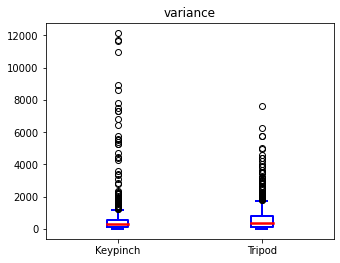

rms


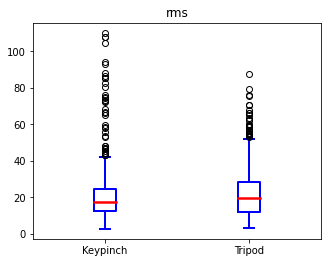

iemg


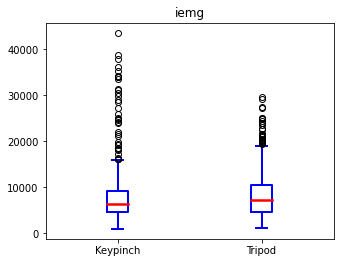

mav


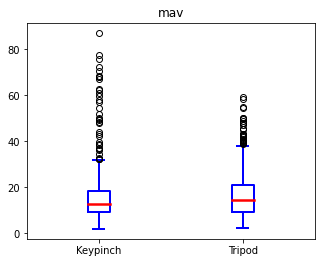

wl


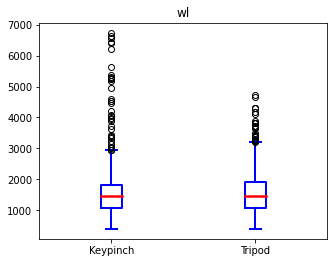

aac


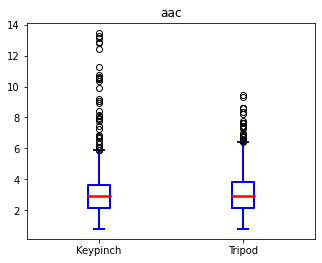

dasdv


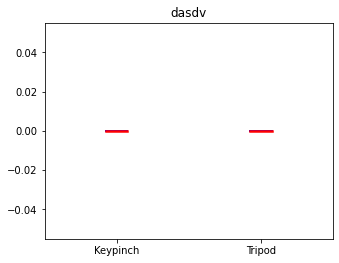

zc


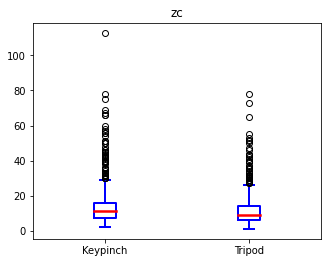

wamp


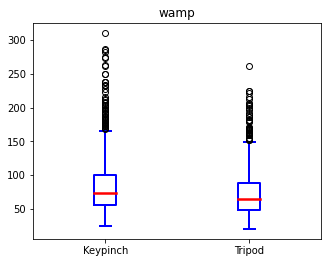

myop


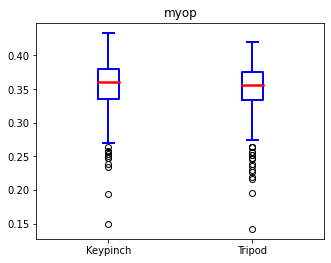

variance.1


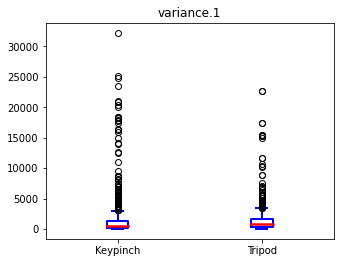

rms.1


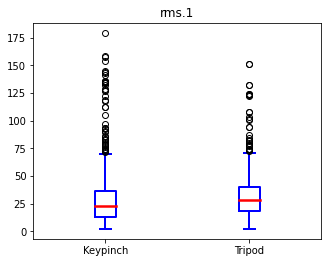

iemg.1


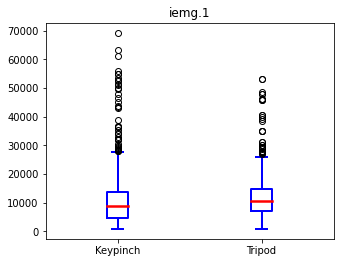

mav.1


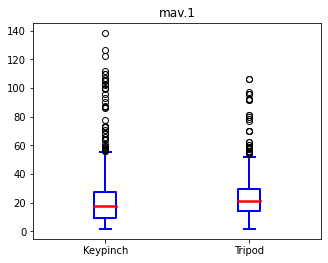

wl.1


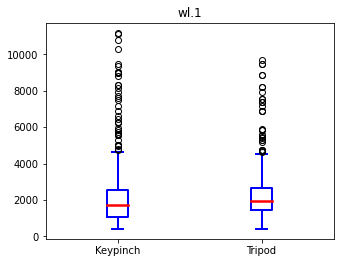

aac.1


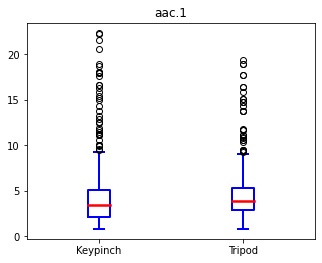

dasdv.1


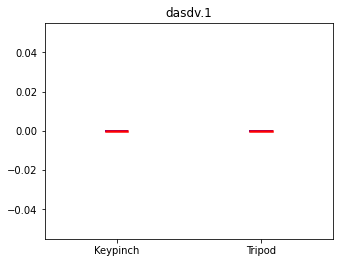

zc.1


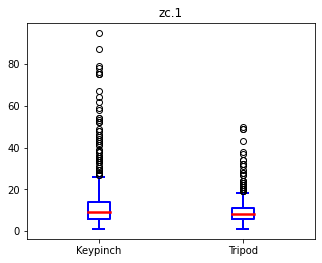

wamp.1


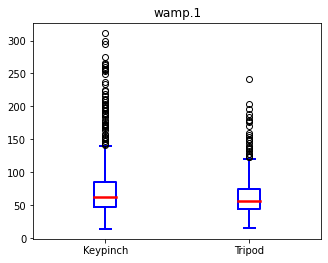

myop.1


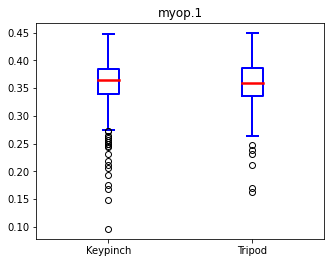

variance.2


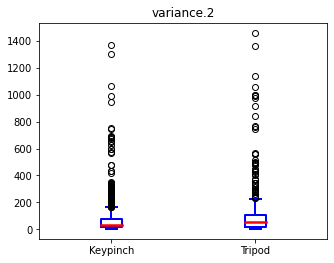

rms.2


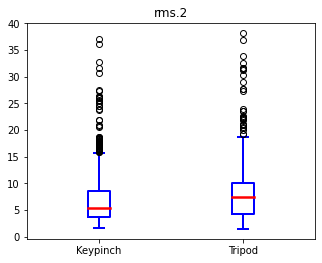

iemg.2


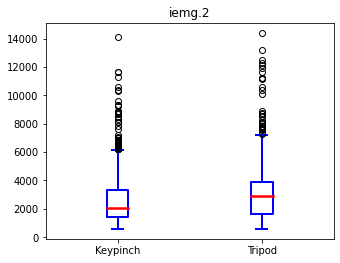

mav.2


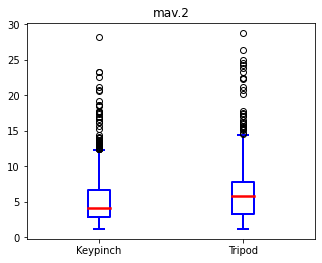

wl.2


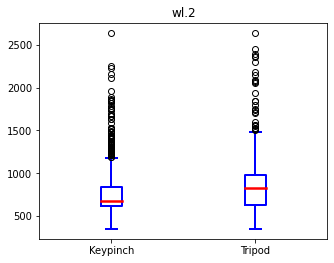

aac.2


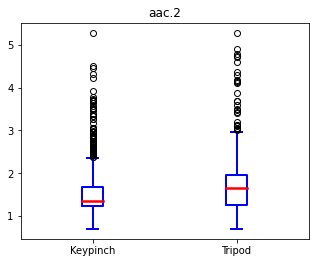

dasdv.2


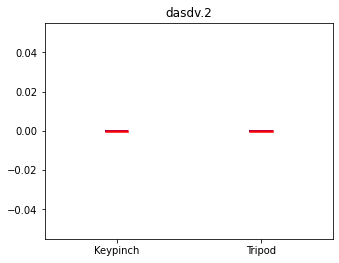

zc.2


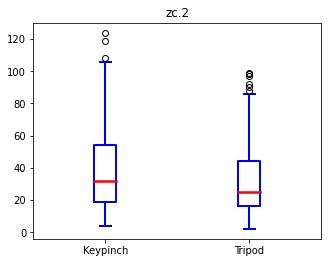

wamp.2


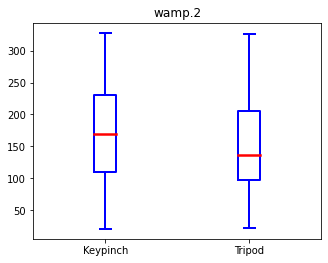

myop.2


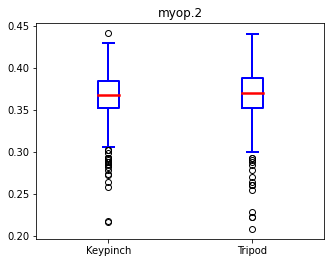

variance.3


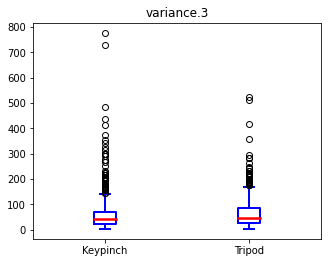

rms.3


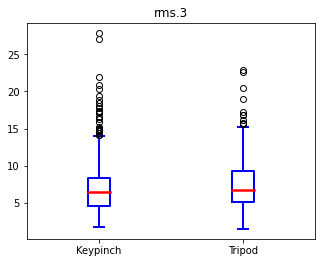

iemg.3


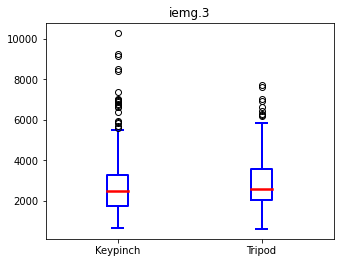

mav.3


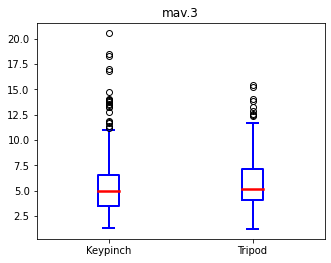

wl.3


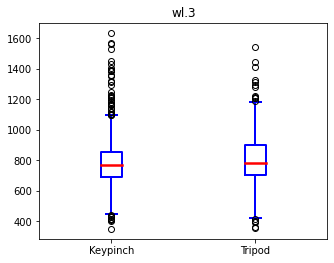

aac.3


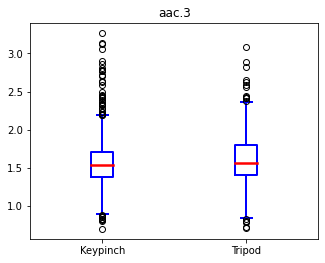

dasdv.3


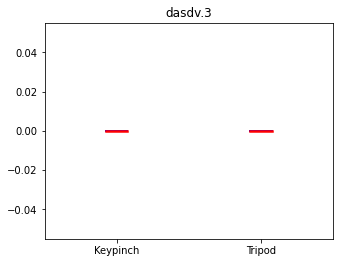

zc.3


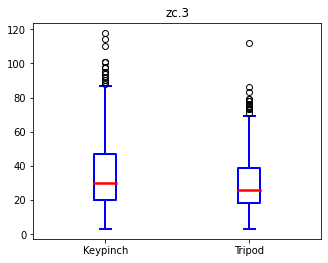

wamp.3


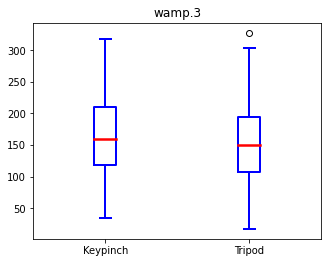

myop.3


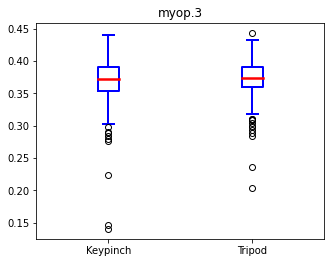

mean_0


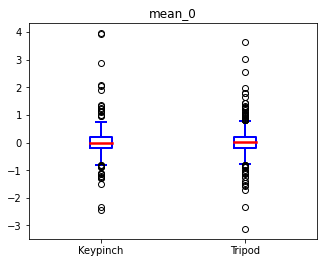

mean_1


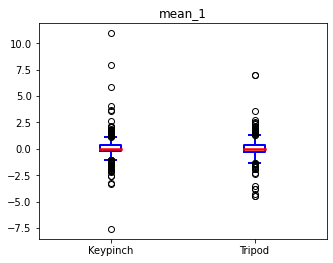

mean_2


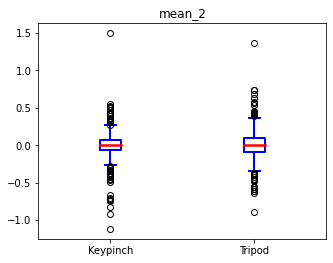

mean_3


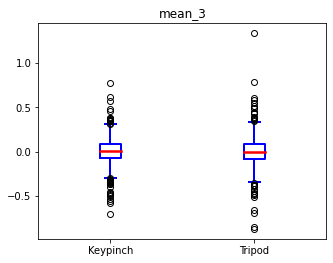

skew_0


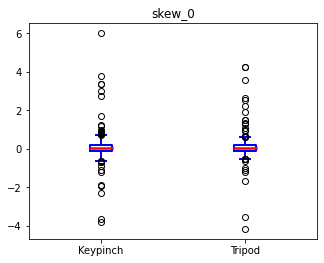

skew_1


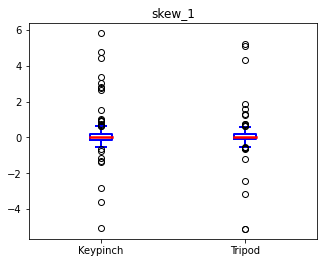

skew_2


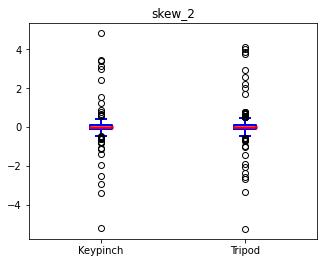

skew_3


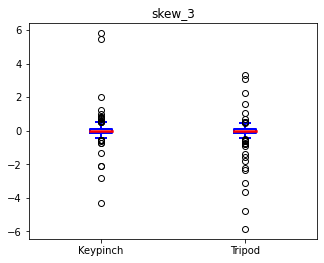

kurt_0


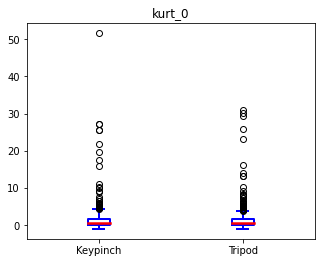

kurt_1


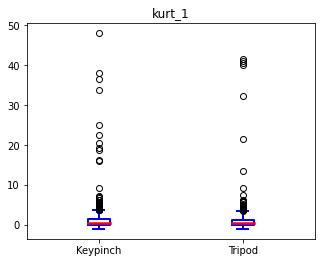

kurt_2


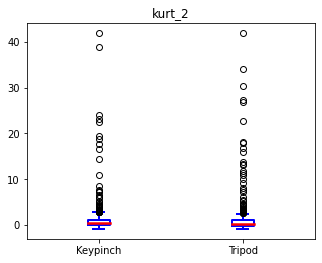

kurt_3


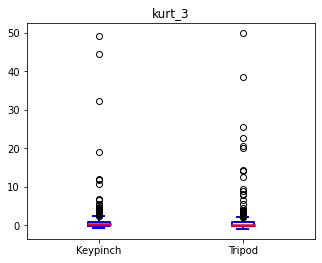

max_0


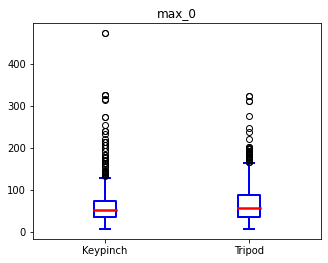

max_1


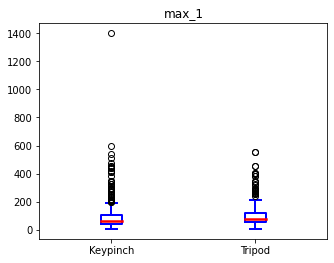

max_2


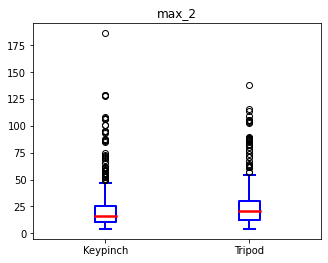

max_3


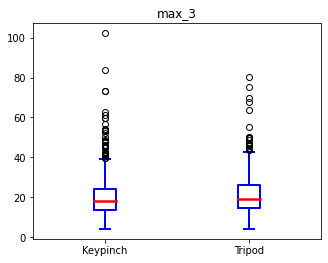

max_d_h2h1_0


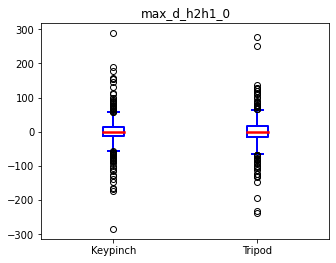

max_d_h2h1_1


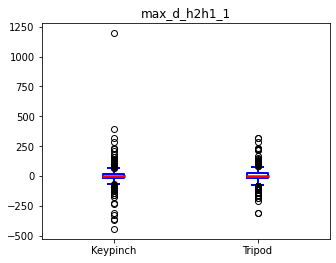

max_d_h2h1_2


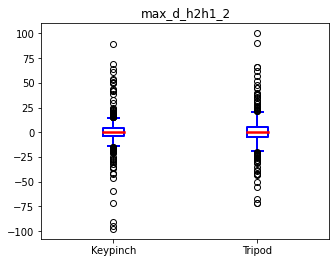

max_d_h2h1_3


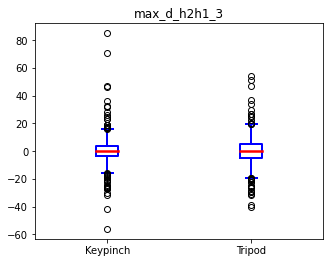

A3_mean


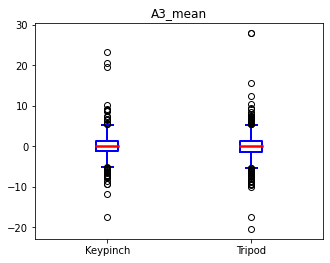

A3_std


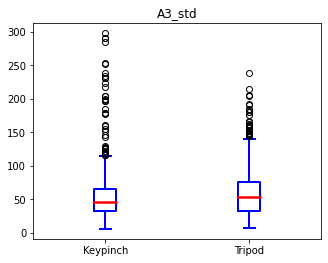

A3_energy


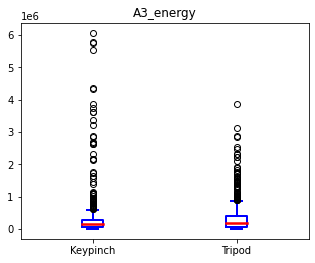

A3_entropy


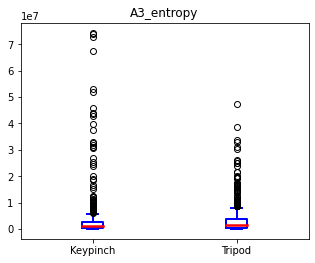

D3_mean


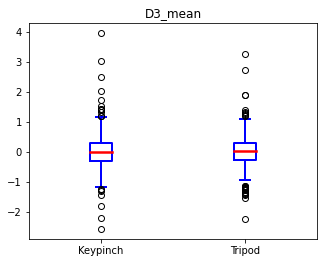

D3_std


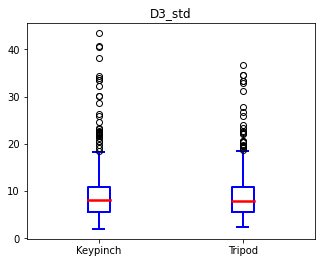

D3_energy


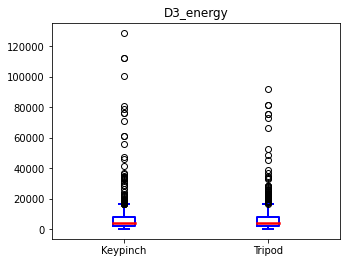

D3_entropy


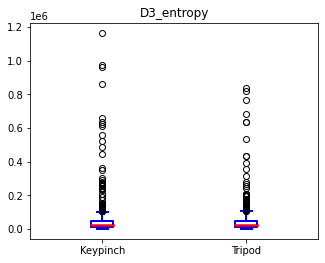

D2_mean


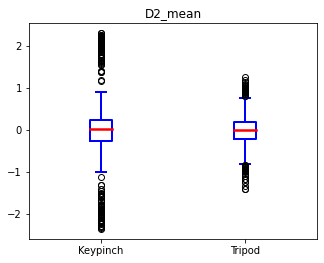

D2_std


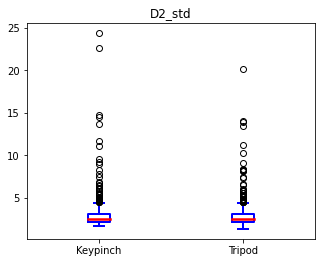

D2_energy


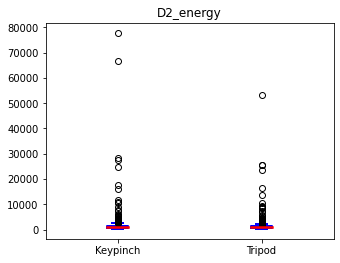

D2_entropy


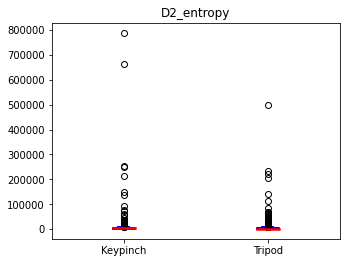

D1_mean


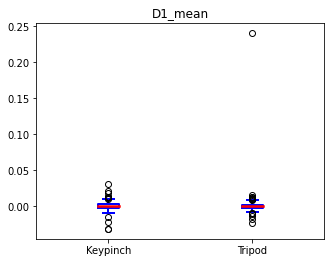

D1_std


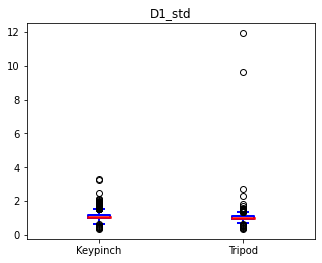

D1_energy


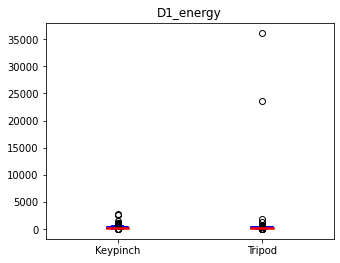

D1_entropy


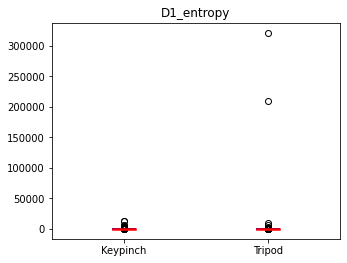

A3_mean.1


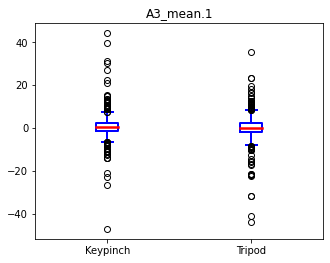

A3_std.1


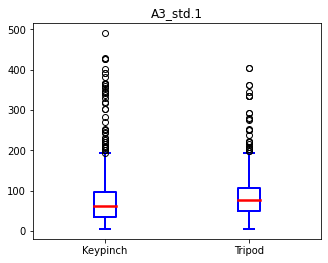

A3_energy.1


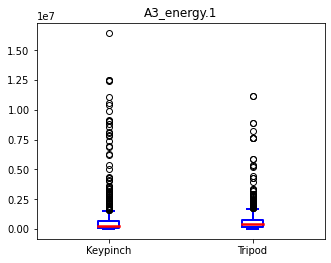

A3_entropy.1


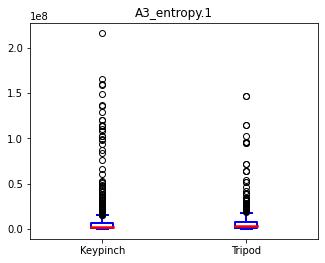

D3_mean.1


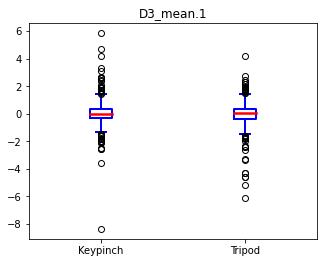

D3_std.1


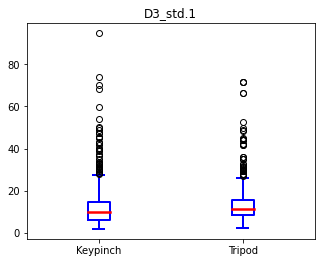

D3_energy.1


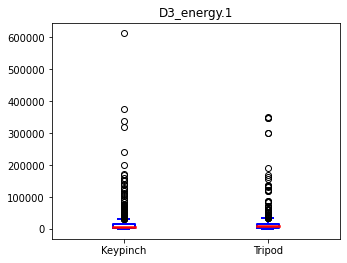

D3_entropy.1


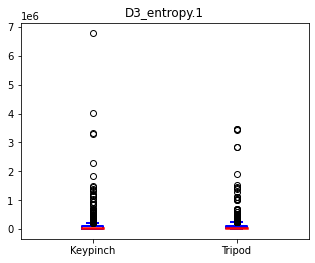

D2_mean.1


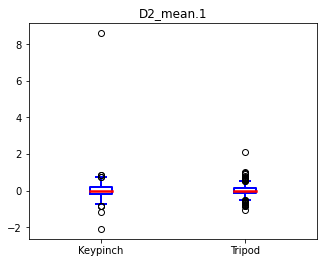

D2_std.1


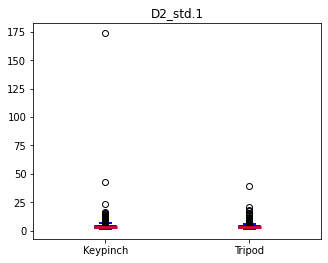

D2_energy.1


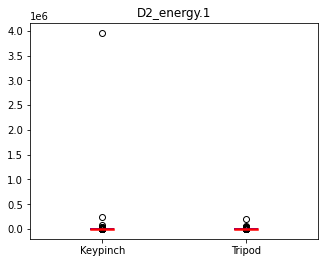

D2_entropy.1


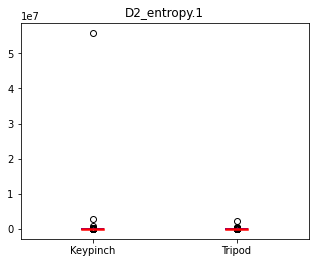

D1_mean.1


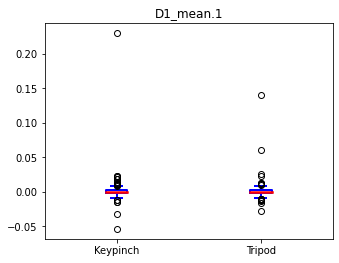

D1_std.1


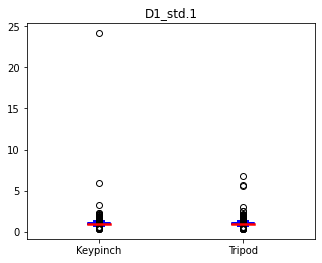

D1_energy.1


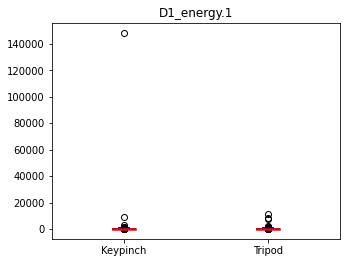

D1_entropy.1


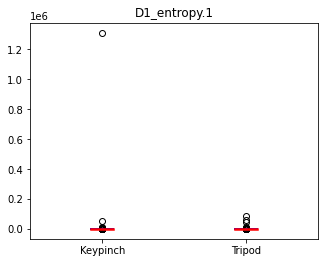

A3_mean.2


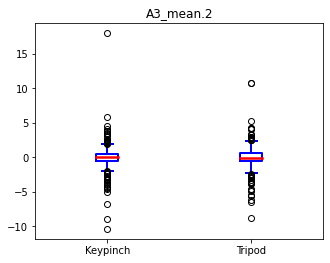

A3_std.2


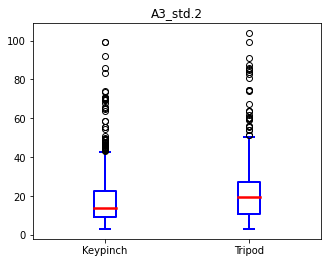

A3_energy.2


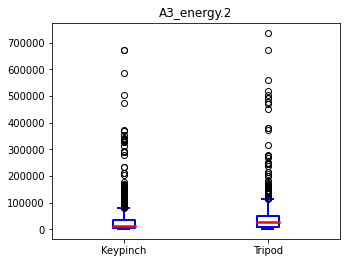

A3_entropy.2


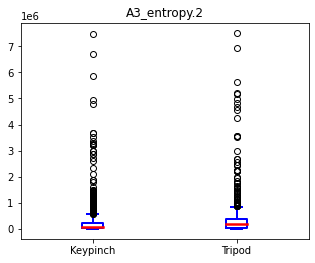

D3_mean.2


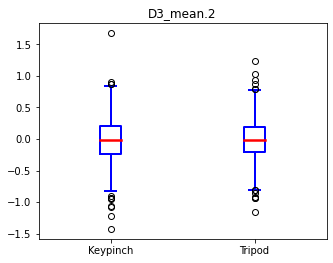

D3_std.2


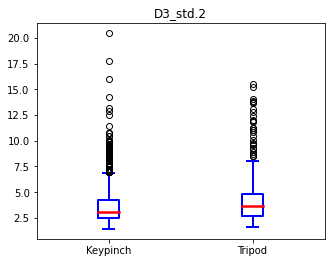

D3_energy.2


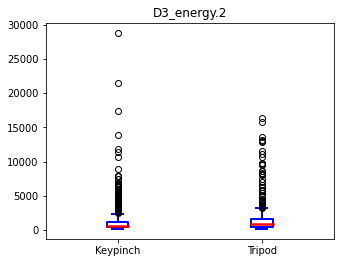

D3_entropy.2


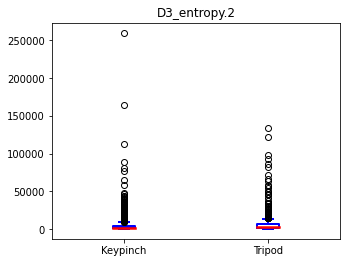

D2_mean.2


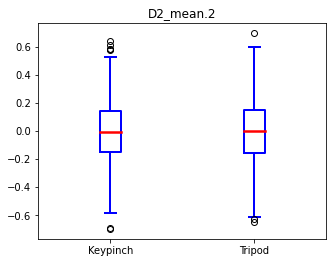

D2_std.2


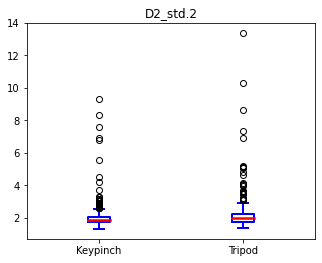

D2_energy.2


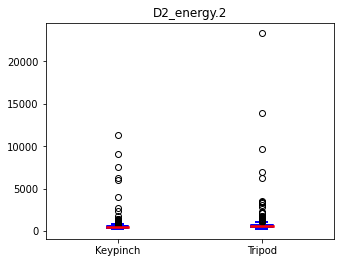

D2_entropy.2


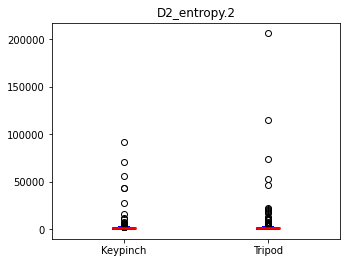

D1_mean.2


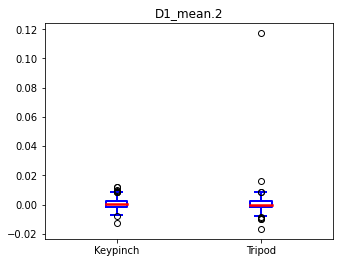

D1_std.2


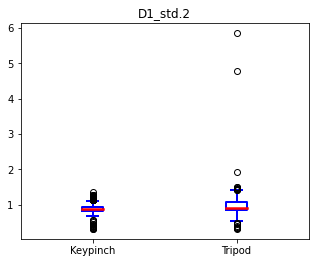

D1_energy.2


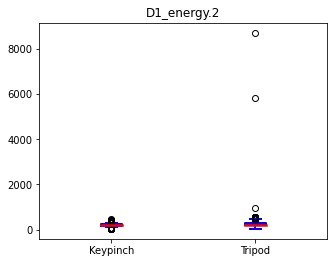

D1_entropy.2


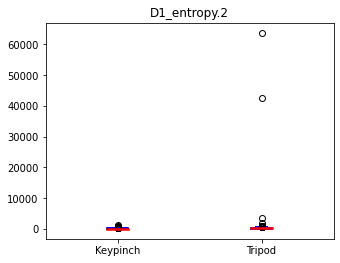

A3_mean.3


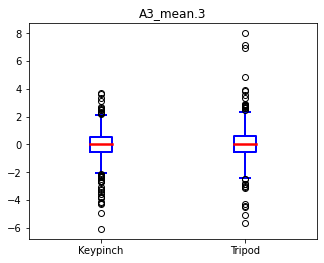

A3_std.3


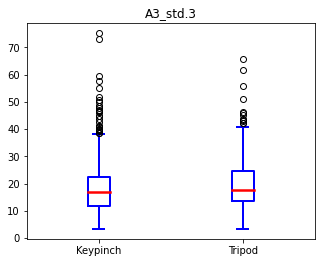

A3_energy.3


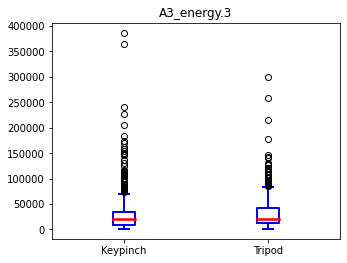

A3_entropy.3


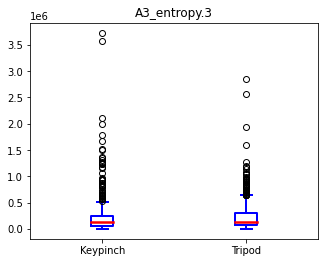

D3_mean.3


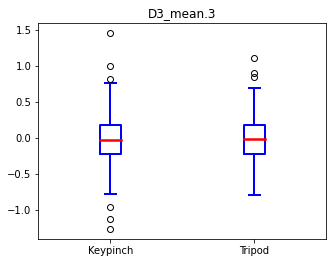

D3_std.3


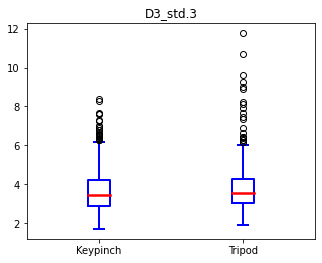

D3_energy.3


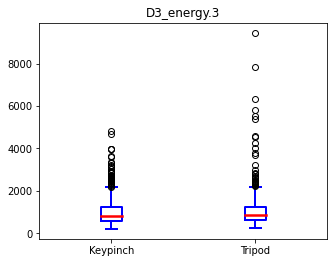

D3_entropy.3


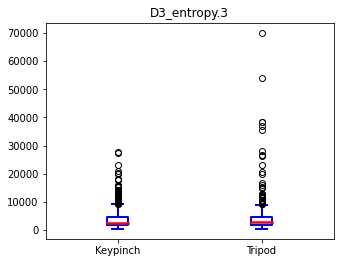

D2_mean.3


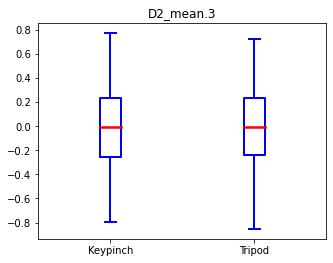

D2_std.3


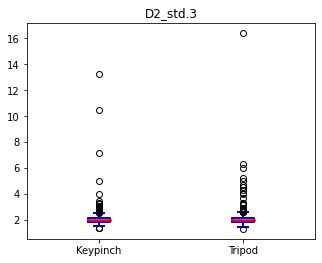

D2_energy.3


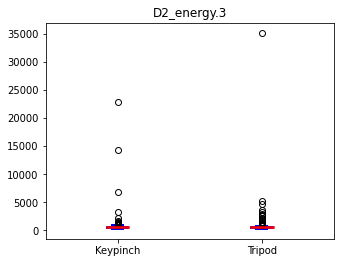

D2_entropy.3


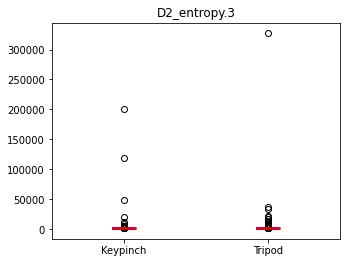

D1_mean.3


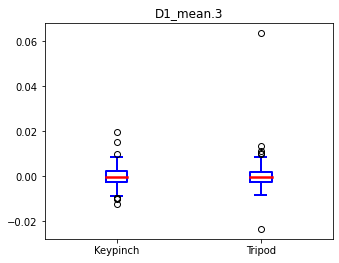

D1_std.3


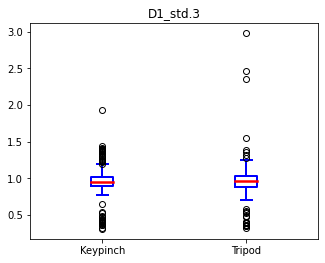

D1_energy.3


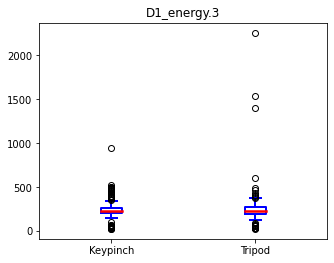

D1_entropy.3


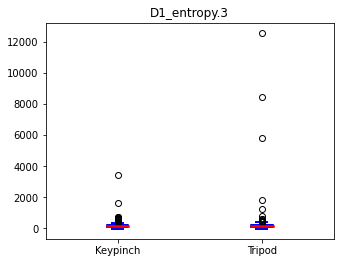

FR_0


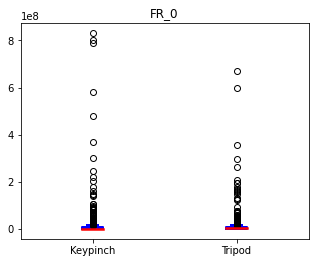

FR_1


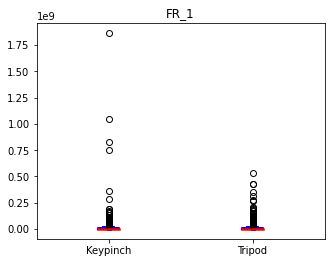

FR_2


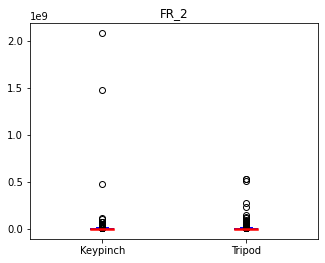

FR_3


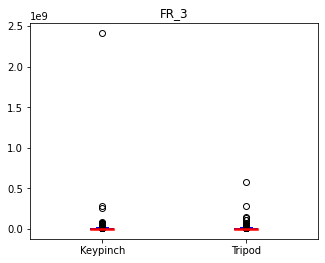

MNP_0


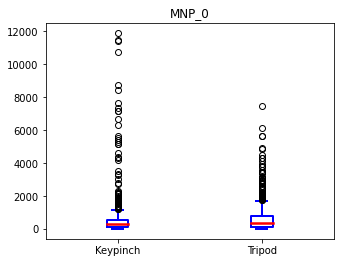

MNP_1


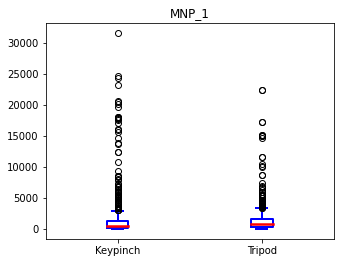

MNP_2


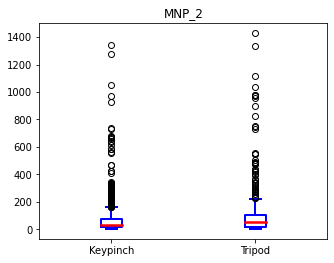

MNP_3


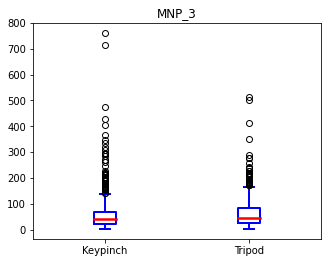

TOT_0


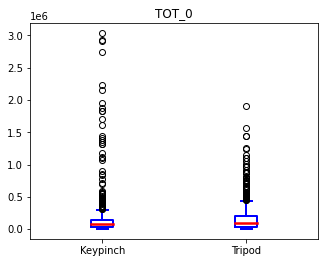

TOT_1


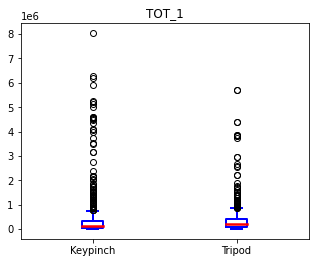

TOT_2


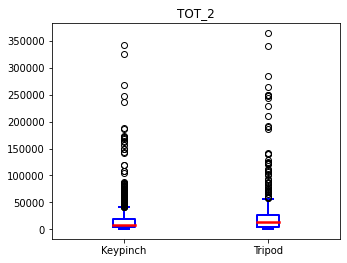

TOT_3


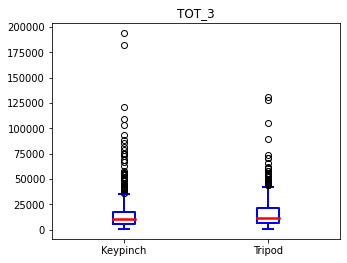

MNF_0


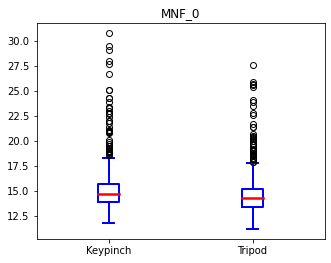

MNF_1


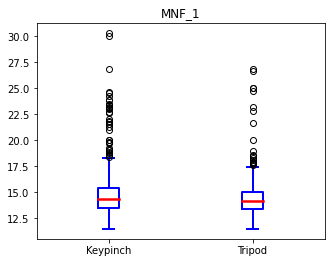

MNF_2


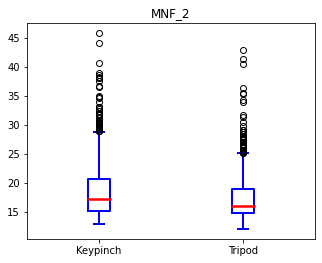

MNF_3


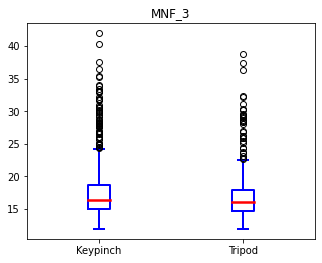

Label


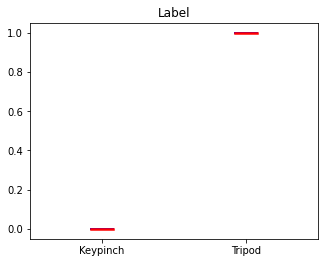

In [14]:

# Python program to illustrate
# boxplot 
  
# importing the required module

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

result = pd.read_csv(output_file_Train)


# Plotting boxplots
for column in result.columns:
    boxplot1(result, column)

In [15]:

import numpy as np
import pandas as pd
import os
import csv
import cv2
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score

In [16]:


Train_set = pd.read_csv(output_file_Train)
Test_set  = pd.read_csv(output_file_Test)


In [17]:
x=[]
xt=[]
y=[]
yt=[]



In [18]:
x = Train_set.iloc[:,0:-1-1].values
xt =  Test_set.iloc[:,0:-1-1].values

y = Train_set.iloc[:,-1].values
yt= Test_set.iloc[:,-1].values


In [19]:
x


array([[5.07739290e+02, 2.25330776e+01, 8.76294923e+03, ...,
        1.40108942e+01, 1.44923507e+01, 1.72612188e+01],
       [8.86053399e+02, 2.97668407e+01, 1.15616685e+04, ...,
        1.42638395e+01, 1.40802281e+01, 1.85214833e+01],
       [1.20378395e+03, 3.46988685e+01, 1.37637413e+04, ...,
        1.37100790e+01, 1.32387994e+01, 1.86747729e+01],
       ...,
       [1.00517805e+03, 3.17045510e+01, 1.14592061e+04, ...,
        1.46232033e+01, 1.37039584e+01, 1.51697028e+01],
       [5.40499487e+03, 7.35193881e+01, 2.42431346e+04, ...,
        1.28301485e+01, 1.41255598e+01, 1.57636326e+01],
       [3.38011286e+02, 1.83990632e+01, 6.77430461e+03, ...,
        1.65070104e+01, 2.30740385e+01, 2.04958794e+01]])

In [24]:
x_train = x
y_train = y
x_test = xt
y_test = yt

In [25]:
#Decision Tree Classifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

#from sklearn.metrics import accuracy_score
#Assign model with Decision Tree classifier
acc=[]
depth=[]
for mdepth in range(2, 20, 1):
    
    
    model1 = DecisionTreeClassifier(criterion = "gini",  #gini entropy
            random_state = 17000,max_depth=mdepth, min_samples_leaf=5)

    model1.fit(x_train, y_train)
    
    #predicting the traget variable using testing variables
    y_pred1 = model1.predict(x_test)
    #Results
    #print("Decision Tree Results")
    #print("Decision Tree Accuracy: ",accuracy_score(y_test, y_pred1)*100,"%")
    acc.append(accuracy_score(y_test, y_pred1))
    depth.append(mdepth)
#printing results of loop
#print(acc)
#print(depth)
max_acc_index = acc.index(max(acc))  
#print (max_acc_index)
print ('Optimum Depth is = ', depth[max_acc_index])
acc_max =   acc[max_acc_index]
print('Training ACC=', acc_max*100,'%')
optimum_depth = depth[max_acc_index]

#Using optimum depth value to train the model 
optimum_model = DecisionTreeClassifier(max_depth = optimum_depth) 
optimum_model.fit(x_train, y_train)

#Test the model 
y_pred = optimum_model.predict(x_test)




orig_class = y_test
pred_class = y_pred

print('ACC Test = ',accuracy_score(orig_class, pred_class))
print('RECALL = ', recall_score(orig_class, pred_class, average='micro'))
print('PRECISION = ', precision_score(orig_class, pred_class, average='micro'))
print('F1 SCORE = ', f1_score(orig_class, pred_class,  average='micro'))

y_pred=[]

Optimum Depth is =  3
Training ACC= 54.56989247311827 %
ACC Test =  0.5456989247311828
RECALL =  0.5456989247311828
PRECISION =  0.5456989247311828
F1 SCORE =  0.5456989247311828


In [26]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

# Train a single random forest classifier
clf = RandomForestClassifier(max_depth=2, random_state=0, n_estimators = 100)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

# Create a confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)


orig_class = y_test
pred_class = y_pred

print('ACC = ',accuracy_score(orig_class, pred_class))
print('RECALL = ', recall_score(orig_class, pred_class, average='micro'))
print('PRECISION = ', precision_score(orig_class, pred_class, average='micro'))
print('F1 SCORE = ', f1_score(orig_class, pred_class,  average='micro'))
y_pred =[]

ACC =  0.41935483870967744
RECALL =  0.41935483870967744
PRECISION =  0.41935483870967744
F1 SCORE =  0.41935483870967744


In [27]:
# Optimum Random forest with grid search 
#Define Parameters

max_depth=[2, 8, 16, 24]
n_estimators = [32, 64, 128, 256]

param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)

# Build the grid search
dfrst = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=700)
grid = GridSearchCV(estimator=dfrst, param_grid=param_grid, cv = 4)
grid_results = grid.fit(x_train, y_train)

# Summarize the results in a readable format
#print("Best: {0}, using {1}".format(grid_results.cv_results_['mean_test_score'], grid_results.best_params_))

results_df = pd.DataFrame(grid_results.cv_results_)
results_df

n,d  = grid_results.best_params_
#print('n is =', n)
# Extract the best  forest
best_clf = grid_results.best_estimator_
y_pred_train = best_clf.predict(x_train)

# Create a confusion matrix of training samples 
cnf_matrix = confusion_matrix(y_train, y_pred_train)
print('cnf_matrix of training', cnf_matrix)
print("Acc Train: ", clf.score(x_train, y_train))

# Extract the best  forest for test
y_pred_test= best_clf.predict(x_test)

# Create a confusion matrix of training samples 
cnf_matrix = confusion_matrix(y_test, y_pred_test)
print('cnf_matrix of testing', cnf_matrix)

print(classification_report(y_test , y_pred_test))


orig_class = y_test
pred_class = y_pred_test

print('ACC = ',accuracy_score(orig_class, pred_class))
print('RECALL = ', recall_score(orig_class, pred_class, average='micro'))
print('PRECISION = ', precision_score(orig_class, pred_class, average='micro'))
print('F1 SCORE = ', f1_score(orig_class, pred_class,  average='micro'))

cnf_matrix of training [[648   0]
 [  0 620]]
Acc Train:  0.667981072555205
cnf_matrix of testing [[ 81 167]
 [ 78  46]]
              precision    recall  f1-score   support

         0.0       0.51      0.33      0.40       248
         1.0       0.22      0.37      0.27       124

    accuracy                           0.34       372
   macro avg       0.36      0.35      0.34       372
weighted avg       0.41      0.34      0.36       372

ACC =  0.34139784946236557
RECALL =  0.34139784946236557
PRECISION =  0.34139784946236557
F1 SCORE =  0.34139784946236557


Text(0, 0.5, 'AW1')

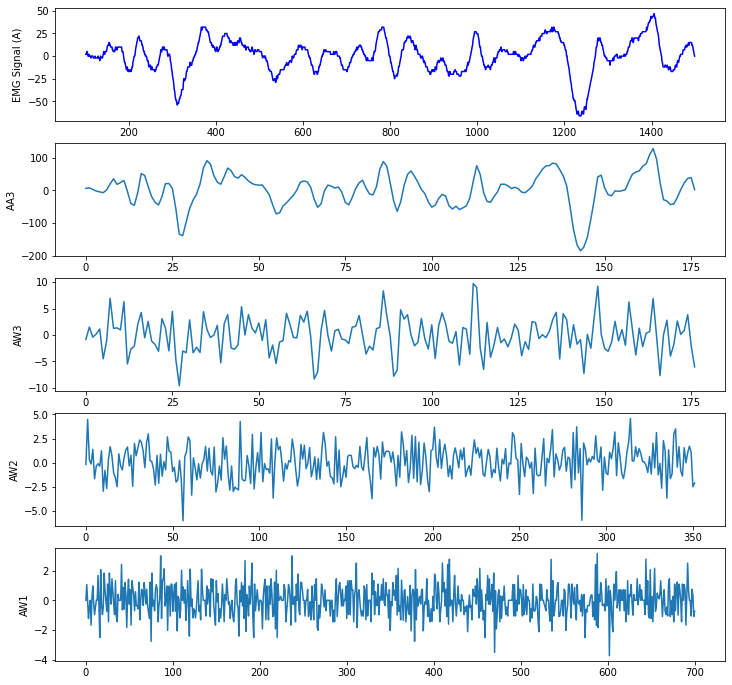

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
import pandas as pd
import math

data=[]
#data =  pd.read_csv('D:/PROJECTS/HPID_12/Train/Subject_Train/sagar-keypinch-1.csv')
data =  pd.read_csv('D:/VIT/Sem 5 (3 yr)/edi/HPID11/Train/Subjecttrain/divya-precision-1.csv')
data_A = data.iloc[101:1500,3]
A_coeffs = pywt.wavedec(data_A, 'db2', level=3)
AA3, AW3, AW2, AW1 = A_coeffs

fig, axs = plt.subplots(5, figsize=(12,12))
axs[0].plot(data_A,'b')
axs[0].set_ylabel('EMG Signal (A)')
axs[1].plot(AA3)
axs[1].set_ylabel('AA3')
axs[2].plot(AW3)
axs[2].set_ylabel('AW3')
axs[3].plot(AW2)
axs[3].set_ylabel('AW2')
axs[4].plot(AW1)
axs[4].set_ylabel('AW1')

In [31]:
def notch_filter(x, samplerate, plot=False):
 
    x = x - np.mean(x)

    high_cutoff_notch = 49 / (samplerate / 2)
    low_cutoff_notch = 51 / (samplerate / 2)

    # Band Stop Filter (BSF) or Band Reject Filter
    [b, a] = signal.butter(4, [high_cutoff_notch, low_cutoff_notch], btype='stop')

    x_filt = signal.filtfilt(b, a, x.T)

    if plot:
        t = np.arange(0, len(x) / samplerate, 1 / samplerate)
        plt.plot(t, x)
        plt.plot(t, x_filt.T, 'k')
        plt.legend(['Original', 'Filtered'], loc = 'best')
        plt.autoscale(tight=True)
        plt.xlabel('Time')
        plt.ylabel('Amplitude (mV)')
        plt.show()

    return x_filt


def bp_filter(x, low_f, high_f, samplerate, plot=False):
    # x = x - np.mean(x)

    low_cutoff_bp = low_f / (samplerate / 2)
    high_cutoff_bp = high_f / (samplerate / 2)

    [b, a] = signal.butter(5, [low_cutoff_bp, high_cutoff_bp], btype='bandpass')

    x_filt = signal.filtfilt(b, a, x)
    #print(len(x))

    if plot:
        t = np.arange(0, len(x.transpose()) / samplerate, 1 / samplerate)
        plt.plot(t, x.transpose())
        plt.plot(t, x_filt.transpose(), 'k')
        plt.legend(['Original', 'Filtered'], loc = 'best')
        plt.autoscale(tight=True)
        plt.xlabel('Time')
        plt.ylabel('Amplitude (mV)')
        plt.show()

    return x_filt

In [32]:
def plot_freq_band (data_in):
    fs = 512                                # Sampling rate (512 Hz)
    # Get real amplitudes of FFT (only in postive frequencies)
    fft_vals = np.absolute(np.fft.rfft(data_in))
    
    # Get frequencies for amplitudes in Hz
    fft_freq = np.fft.rfftfreq(len(data_in), 1.0/fs)
    #print(fft_freq)
    # Define EEG bands
    eeg_bands = {' 0 - 10Hz': (0, 10),
                 '11 - 20Hz': (11, 20),
                 '21 - 30Hz': (21, 30),
                 '31 - 40Hz': (31, 40),
                 '41 - 50Hz': (41, 50)}
                # '45 to 100 Hz':(45,100),
                 #'101 to 200 Hz':(101,200)}

    # Take the mean of the fft amplitude for each EEG band
    eeg_band_fft = dict()
    for band in eeg_bands:  
        freq_ix = np.where((fft_freq >= eeg_bands[band][0]) & 
                           (fft_freq <= eeg_bands[band][1]))[0]
        eeg_band_fft[band] = np.mean(fft_vals[freq_ix])

    # Plot the data (using pandas here cause it's easy)
    import pandas as pd
    df = pd.DataFrame(columns=['band', 'val'])
    df['band'] = eeg_bands.keys()
    df['val'] = [eeg_band_fft[band] for band in eeg_bands]
    ax = df.plot.bar(x='band', y='val', legend=False)
    ax.set_xlabel("EEG band")
    ax.set_ylabel("Mean band Amplitude")

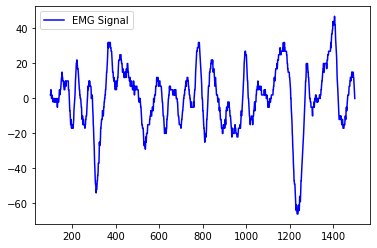

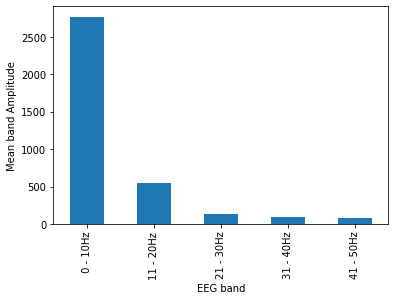

In [33]:
import scipy
import scipy.signal
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np

#data_A = data.iloc[3000:5799,2]
plt.clf()
plt.plot(data_A,'b')
plt.legend(['EMG Signal'], loc = 'best')
plot_freq_band (data_A)
#plt.clf()


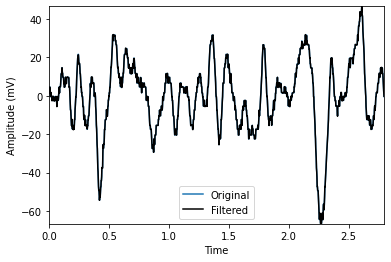

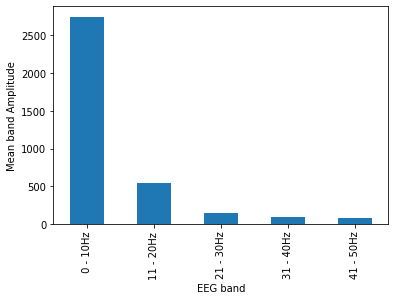

In [34]:
notch_out = notch_filter(data_A, samplerate=500, plot=True)
#plt.clf()
plot_freq_band (notch_out)
#plt.clf()

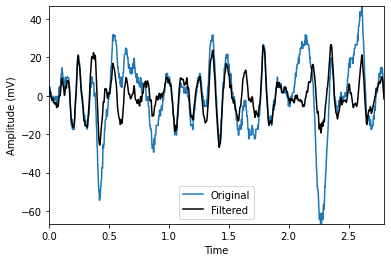

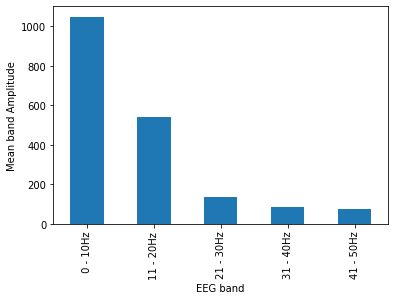

In [35]:
bp_out =  bp_filter(notch_out, low_f=5, high_f=80, samplerate=500, plot=True)
#plt.clf()
plot_freq_band (bp_out)

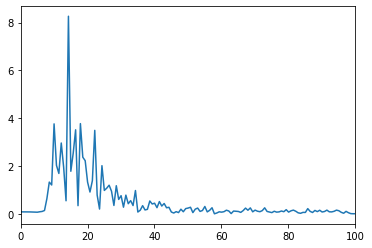

In [36]:
#Power spectral density
from scipy.fftpack import fft, fftfreq
import matplotlib.pyplot as plt
x= bp_out
dt = 0.001
#X = fft(x)
X=fft(x)/len(x)
freq = fftfreq(x.size, d=dt)

# Only keep positive frequencies.
keep = freq>=0
#X = X[keep]
X=X[keep]*2
freq = freq[keep]

ax1 = plt.subplot(111)
ax1.plot(freq, np.absolute(X))#/3000.)
ax1.set_xlim(0,100)

plt.show()

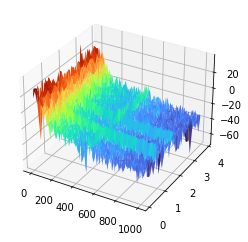

In [37]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy import signal # spectrogram function
from matplotlib import cm # colour map

mysignal =data.iloc[:,1] # CHANGE THE SIGNAL AND SEE PLOT

# basic config
sample_rate = 2000 #11240.  # 
sig_len_secs = 10
frequency = 2000.

# generate thetimepoint
timestamps_secs = np.arange(sample_rate*sig_len_secs) / sample_rate


# extract the spectrum
freq_bins, timestamps, spec = signal.spectrogram(mysignal, sample_rate)

# 3d plot

fig = plt.figure()
#ax = fig.gca(projection='3d')
ax = plt.subplot(1,1,1,projection="3d"); 
ax.plot_surface(freq_bins[:, None], timestamps[None, :], 10.0*np.log10(spec), cmap=cm.turbo)
plt.show()


(1899,)


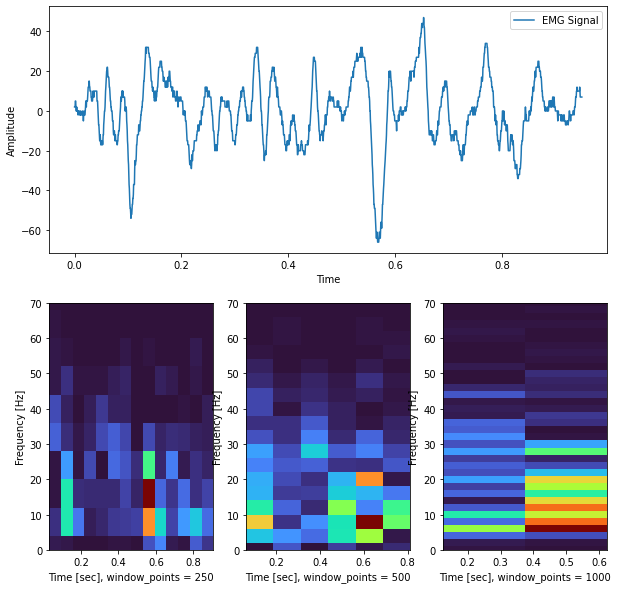

In [38]:
#https://stackoverflow.com/questions/72181057/what-is-the-ideal-parameters-for-spectrogram-of-eeg-signal
#Windowing of signal for analysis and discussion of no of datapoints 
# We clim 500 to be the ideal number of data points 
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

#y_data = np.genfromtxt('signal_value_spectro.csv', delimiter=',',skip_header=0)

Oz=data.iloc[100:1999,3]#
fs = 2000
t = np.arange(len(Oz))/fs

print(t.shape)

nperseg=250
f250, t250, Sxx_250 = signal.spectrogram(Oz, fs, nperseg=nperseg ,noverlap=nperseg//2,window=signal.get_window('hann',nperseg))
nperseg=500
f500, t500, Sxx_500 = signal.spectrogram(Oz, fs, nperseg=nperseg , noverlap=nperseg//2,window=signal.get_window('hann',nperseg))
nperseg=1000
f1000, t1000, Sxx_1000 = signal.spectrogram(Oz, fs, nperseg=nperseg ,noverlap=nperseg//2,window=signal.get_window('hann',nperseg))
#50% OVERLAP FOR ALL 3 
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.plot(np.arange(len(Oz))/fs,Oz)  
plt.legend(['EMG Signal'], loc = 'best')
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.subplot(234)
plt.pcolormesh(t250, f250, Sxx_250, shading='auto',cmap = 'turbo')
plt.ylim([0,70])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec], window_points = 250')
plt.subplot(235)
plt.pcolormesh(t500, f500, Sxx_500, shading='auto',cmap = 'turbo')
plt.ylim([0,70])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec], window_points = 500')
plt.subplot(236)
plt.pcolormesh(t1000, f1000, Sxx_1000, shading='auto',cmap = 'turbo')
plt.ylim([0,70])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec], window_points = 1000')


plt.show()

(1899,)


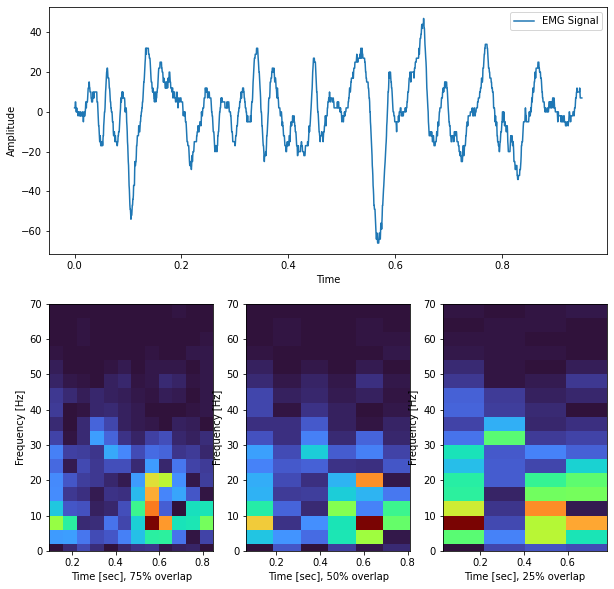

In [39]:
#https://stackoverflow.com/questions/72181057/what-is-the-ideal-parameters-for-spectrogram-of-eeg-signal
#  overlapping of signal analysis and discussion of lenght of overlapping window
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

#y_data = np.genfromtxt('signal_value_spectro.csv', delimiter=',',skip_header=0)

Oz=data.iloc[100:1999,3]#
fs = 2000
t = np.arange(len(Oz))/fs

print(t.shape)

nperseg=500
f250, t250, Sxx_250 = signal.spectrogram(Oz, fs, nperseg=nperseg ,noverlap=nperseg//1.334,window=signal.get_window('hann',nperseg))
nperseg=500
f500, t500, Sxx_500 = signal.spectrogram(Oz, fs, nperseg=nperseg , noverlap=nperseg//2,window=signal.get_window('hann',nperseg))
nperseg=500
f1000, t1000, Sxx_1000 = signal.spectrogram(Oz, fs, nperseg=nperseg ,noverlap=nperseg//4,window=signal.get_window('hann',nperseg))
#ALL 3 have  500 Datapoints 
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.plot(np.arange(len(Oz))/fs,Oz)  
plt.legend(['EMG Signal'], loc = 'best')
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.subplot(234)
plt.pcolormesh(t250, f250, Sxx_250, shading='auto',cmap = 'turbo')
plt.ylim([0,70])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec], 75% overlap')
plt.subplot(235)
plt.pcolormesh(t500, f500, Sxx_500, shading='auto',cmap = 'turbo')
plt.ylim([0,70])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec], 50% overlap')
plt.subplot(236)
plt.pcolormesh(t1000, f1000, Sxx_1000, shading='auto',cmap = 'turbo')
plt.ylim([0,70])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec], 25% overlap')


plt.show()

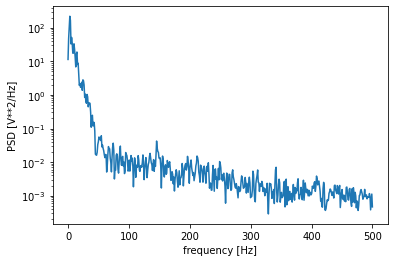

In [40]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html
# default Hann window an overlap of 50% 
#Compute and plot the power spectral density.
from scipy import signal
import matplotlib.pyplot as plt
rng = np.random.default_rng()
fs = 1000
x=data.iloc[100:2999,3]
f, Pxx_den = signal.welch(x, fs, nperseg=1024)
plt.semilogy(f, Pxx_den)
#plt.ylim([0.5e-3, 1])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

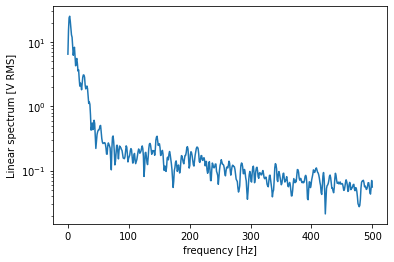

In [41]:
#compute and plot the power spectrum.
f, Pxx_spec = signal.welch(x, fs, 'flattop', 1024, scaling='spectrum')
plt.figure()
plt.semilogy(f, np.sqrt(Pxx_spec))
plt.xlabel('frequency [Hz]')
plt.ylabel('Linear spectrum [V RMS]')
plt.show()

'''
#this code is probably causing problem of accuracy
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values=np.NaN, strategy ='mean')
imputer = imputer.fit(x)
#x = imputer.transform(x)

imputer_test = imputer.fit(xt)
#xt = imputer_test.transform(xt)
'''